In [1]:
import pandas as pd
import numpy as np
import openml
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from typing import Optional
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from sklearn import svm
import colorsys

# 1. Calculating epp measure

### 1.1 Download results from OpenML

In [2]:
# Task ids with 2 calsses
suite = openml.study.get_suite(99)
task_ids = suite.tasks
binary_classification_tasks = [] 
for task_id in task_ids:
    task = openml.tasks.get_task(task_id)
    if task.class_labels and len(task.class_labels) == 2:
        binary_classification_tasks.append(task_id)
print("Task ids with 2 calsses:", binary_classification_tasks)

Task ids with 2 calsses: [3, 15, 29, 31, 37, 43, 49, 219, 3021, 3902, 3903, 3904, 3913, 3917, 3918, 7592, 9910, 9946, 9952, 9957, 9971, 9976, 9977, 9978, 10093, 10101, 14952, 14954, 14965, 125920, 146819, 146820, 167120, 167125, 167141]


In [ ]:
# download flows results for task with 2 classes
page_size = 10000
all_final_results = []

for licz in binary_classification_tasks:
    if licz == 31: # this task couse an error
        continue 
    task_id_filter = licz
    all_results = []
    
    # download only metadata
    flows = openml.evaluations.list_evaluations(
        function="area_under_roc_curve",
        tasks=[task_id_filter],
        output_format="dataframe",
        size=page_size,
        per_fold=False  
    )['flow_id'].unique()

    for flow_id in flows:
        # download only one row for given flow_id
        evaluation = openml.evaluations.list_evaluations(
            function="area_under_roc_curve",
            tasks=[task_id_filter],
            flows=[flow_id],
            output_format="dataframe",
            offset=0,
            size=1,  
            per_fold=True
        )

        if not evaluation.empty:
            all_results.append(evaluation)

    # aggregate results
    wyniki_i = pd.concat(all_results, ignore_index=True)

    rows = []
    for _, row in wyniki_i.iterrows():
        flow_id = row['flow_id']
        values = row['values']
        for i, value in enumerate(values):
            rows.append({'player': flow_id, 'round': i + 1, 'score': value})

    ostateczne_wyniki = pd.DataFrame(rows)
    all_final_results.append(ostateczne_wyniki)

### 1.2 Calcuate epp for each flow

In [56]:
# function to calculate EPP - author:
def calculate_epp_leaderboard(
    tournament_df: pd.DataFrame,
    player_col: str = "player",
    round_col: str = "round",
    score_col: str = "score",
    greater_score_is_better: bool = True,
    reference_player: Optional[str] = None,  # this line was changed due to python version
) -> pd.DataFrame:
    tournament_df = tournament_df[[player_col, round_col, score_col]].sort_values(
        [round_col, player_col]
    )

    all_unique_players = tournament_df[player_col].unique()
    each_round_players = tournament_df.groupby(round_col)[player_col]

    if any(each_round_players.unique().apply(set) != set(all_unique_players)):
        raise ValueError("Some players did not score in every round.")
    if any(each_round_players.value_counts() > 1):
        raise ValueError("Some players scored more than once in a round.")

    n_players = len(all_unique_players)
    n_rounds = len(each_round_players)

    comparison_operator = np.greater if greater_score_is_better else np.less

    if reference_player is not None:
        reference_mask = all_unique_players == reference_player
        if not any(reference_mask):
            raise ValueError(f"Player '{reference_player}' not found.")
        reference_index = np.arange(n_players)[reference_mask][0]
    else:
        reference_index = 0

    scores = tournament_df[score_col].to_numpy(dtype=float).reshape((1, n_rounds, -1))
    n_wins = comparison_operator(scores.T, scores).sum(axis=1, dtype=float)

    # adjust for ties
    n_wins += (n_rounds - (n_wins + n_wins.T)) / 2

    endog = np.delete(
        np.column_stack([n_wins.flatten(), n_rounds - n_wins.flatten()]),
        np.arange(n_players) * (n_players + 1),
        axis=0,
    )

    exog = np.delete(
        np.delete(
            np.repeat(np.eye(n_players), n_players, axis=0)
            - np.tile(np.eye(n_players), (n_players, 1)),
            np.arange(n_players) * (n_players + 1),
            axis=0,
        ),
        reference_index,
        axis=1,
    )

    model = sm.GLM(endog, exog, family=sm.families.Binomial())
    fit_results = model.fit()

    leaderboard_df = pd.DataFrame(
        {
            "player": all_unique_players,
            "epp": np.insert(fit_results.params, reference_index, 0.0),
            "p_value": np.insert(fit_results.pvalues, reference_index, np.nan),
        }
    ).sort_values("epp", ascending=False, ignore_index=True)

    return leaderboard_df

In [ ]:
 # Calcuate EPP for all tasks
epp = []
for i in range(len(all_final_results)):
    if i in[3,4,6]:
        continue
    epp.append(calculate_epp_leaderboard(all_final_results[i]))

### 1.3 Save and import results (to txt files) 

In [ ]:
# save epp to txt file
with open("epp.txt", "w") as file:
    for i, df in enumerate(epp):
        if i in [3,4,6]:
            continue
        file.write(f"Task_id = {binary_classification_tasks[i]}\n") 
        df.to_csv(file, sep="\t", index=False)
        file.write("\n")

In [3]:
# import epp resulst from txt file
epp_score = []

with open('epp.txt', "r") as file:
    lines = file.readlines()  
    temp_df = None
    task_id = None 
    header = False    

    for line in lines:
        if line.startswith("Task_id"):
            if temp_df is not None:
                epp_score.append(temp_df)
            
            task_id = line.strip().split("= ")[1] 
            temp_df = pd.DataFrame(columns=["flow_id", "epp", "p_value"])
            header = True
        elif line.strip():  
            row_data = line.strip().split("\t")
            
            while len(row_data) < 3:
                row_data.append(None)

            if header: 
                header = False
            else:
                temp_df = pd.concat([temp_df, pd.DataFrame([row_data], columns=["flow_id", "epp", "p_value"])], ignore_index=True)

    if temp_df is not None:
        epp_score.append(temp_df)

for i in range(len(epp_score)):
    epp_score[i] = epp_score[i].apply(pd.to_numeric)

In [ ]:
# save rounds scores to txt file
with open("wyniki.txt", "w") as file:
    for i, df in enumerate(all_final_results):
        file.write(f"Task_id = {binary_classification_tasks[i]}\n") 
        df.to_csv(file, sep="\t", index=False)
        file.write("\n")

In [4]:
# import rounds scores from txt file
rounds_score = []

with open("wyniki.txt", "r") as file:
    lines = file.readlines() 
    temp_df = None
    task_id = None
    header = False
    for line in lines:
        if line.startswith("Task_id"):
            if temp_df is not None:
                rounds_score.append(temp_df)
            
            task_id = line.strip().split("= ")[1] 
            temp_df = pd.DataFrame(columns=["flow_id", "fold_id", "score"])
            header = True
        elif line.strip():
            row_data = line.strip().split("\t")
            
            if len(row_data) == 3:
                if header:
                    header = False
                else:
                    temp_df = pd.concat([temp_df, pd.DataFrame([row_data], columns=["flow_id", "fold_id", "score"])], ignore_index=True)

    if temp_df is not None:
        rounds_score.append(temp_df)

for i in range(len(rounds_score)):
    rounds_score[i] = rounds_score[i].apply(pd.to_numeric)

# 2. Data preparation

In [5]:
# list of analyzed tasks
tasks_id = [3, 15, 29, 49, 3021, 3902, 3903, 3904, 3913, 3917, 3918, 7592, 9910, 9946, 9952, 9957, 9971, 9976, 9977, 9978, 10093, 10101, 14952, 14954, 14965, 125920, 146819, 146820, 167120, 167125, 167141]

In [6]:
# counts of flow_id in epp_score
result_list = []

for df in epp_score:
    counts = df['flow_id'].value_counts().reset_index()
    counts.columns = ['flow_id', 'count'] 
    result_list.append(counts)

counts = pd.concat(result_list).groupby('flow_id').sum().reset_index()
counts.sort_values('count', ascending=False, inplace=True)
counts

flow_id  count
1056     8455     31
1057     8456     31
1070     8693     30
1049     8330     30
1071     8695     30
...       ...    ...
243      1181      1
261      1438      1
844      5886      1
262      1439      1
1194    22863      1

[1195 rows x 2 columns]

In [7]:
# download flow names
def get_flow_name(flow_id):
    try:
        flow = openml.flows.get_flow(flow_id)
        return flow.name
    except:
        return None

counts['flow_name'] = counts['flow_id'].apply(get_flow_name)
counts

flow_id  count                                          flow_name
1056     8455     31  sklearn.pipeline.Pipeline(imputation=sklearn.p...
1057     8456     31  sklearn.pipeline.Pipeline(imputation=sklearn.p...
1070     8693     30  weka.classifiers.meta.MultiSearch(weka.classif...
1049     8330     30  sklearn.pipeline.Pipeline(imputation=openmlstu...
1071     8695     30                         weka.classifiers.trees.J48
...       ...    ...                                                ...
243      1181      1                                        weka.Winnow
261      1438      1                                      classif.rpart
844      5886      1                                           weka.J48
262      1439      1                               classif.randomForest
1194    22863      1  sklearn.pipeline.Pipeline(imputer=sklearn.impu...

[1195 rows x 3 columns]

In [8]:
# function to extract algorithm names from OpenML flow names
def extract_algorithm(dataframe, package, input_names='flow_name', output_name='model_name', dropna=False):

    """
    Extracts machine learning algorithm names from the 'flow_name' column in OpenML 
    and maps them to general classifier categories. The function creates a copy of 
    the input dataframe and returns it with an additional column containing the 
    extracted algorithm names.

    Parameters:
    ----------
    dataframe : pandas.DataFrame
        The input dataframe containing model information.
    package : str or list of str
        The package(s) from which models are extracted (e.g., 'sklearn', 'weka').
    input_names : str, optional, default='flow_name'
        The column name containing full model descriptions, by default in OpenML: flow_name"
    output_name : str, optional, default='model_name'
        The column name where extracted algorithm names will be stored.
    dropna : bool, optional, default=False
        If True, rows with NaN values in the output column will be removed.
    Returns:
    -------
    pandas.DataFrame
        A modified dataframe with the extracted algorithm names categorized into classifier types.
    """

    import pandas as pd
    import numpy as np

    # Validate input types
    if not (isinstance(input_names, str) and isinstance(output_name, str)):
        raise ValueError("input_names and output_name must be strings and dataframe must be a pandas DataFrame!")
    elif not (isinstance(package, str) or isinstance(package, list)):
        raise ValueError("package must be string or a list of strings!")
    elif not isinstance(dataframe, pd.DataFrame):
        raise ValueError("dataframe must be a pandas DataFrame!")
    elif output_name == input_names:
        raise ValueError("output_name and input_names must be different!")
    
    # Define allowed package names
    allowed_packages = ['sklearn', 'weka']

    # Convert package to a list if it is a string
    if isinstance(package, str):
        package = [package]

     # Check if the provided package(s) are valid
    invalid_packages = [p for p in package if p not in allowed_packages]
    if invalid_packages:
        raise ValueError(f"The following packages are not supported: {', '.join(invalid_packages)}")

    # Make a copy of the dataframe to avoid modifying the original data
    X = dataframe.copy()

    # Extract algorithm names for sklearn
    if 'sklearn' in package:



        pattern = r"(?i)^sklearn\.pipeline\.Pipeline.*\.([^\.]+).$"
        pattern_2 = r"(?i)^sklearn\.model_selection.*\.(\S+)$"
        pattern_3 = r"(?i)^sklearn.*\.([^\.]+)$"



        if output_name in X.columns:
            X[output_name] = np.where(
            X[output_name].isna(),
            X[input_names].str.extract(pattern).fillna(method='bfill', axis=1)[0],
            X[output_name])
        else:
            X[output_name] = X[input_names].str.extract(pattern)
            X[output_name] = X[output_name].fillna(X[input_names].str.extract(pattern_2).iloc[:, 0])
            X[output_name] = X[output_name].fillna(X[input_names].str.extract(pattern_3).iloc[:, 0])
        


    # Extract algorithm names for weka
    if 'weka' in package:
        pattern = r"(?i)^weka\.(?:(LogitBoost|MultiSearch)|(?:.*\.)?([^\.]+))$"
        if output_name in X.columns:
            X[output_name] = np.where(
            X[output_name].isna(),
            X[input_names].str.extract(pattern).fillna(method='bfill', axis=1)[0],
            X[output_name])
        else:
            X[output_name] = X[input_names].str.extract(pattern)[1]

        w_pattern = r'^(AttributeSelectedClassifier_|AttributeSelection-|CVParameterSelection_|CfsSubsetEval_BestFirst_|' \
        'BestFirst-CfsSubsetEval-|ThresholdSelector_|InfoGainAttributeEval_Ranker_|MultiClassClassifier_|GainRatioAttributeEval_|' \
        'Ranker-|InfoGain-|ReplaceMissingValues-|Standardize-|Standardize_|ReliefF-|MultiScheme_|PrincipalComponents_|FilteredClassifier_|' \
        'InputMappedClassifier_|PKIDiscretize-|IterativeClassifierOptimizer_|ClassificationViaRegression_|Discretize_|MultiClassClassifierUpdateable_|' \
        'MultiSearch_|MultiFilter_|ReplaceMissingValues_|Ranker_)'
        while True:
            old_model_names = X[output_name].copy()
            X[output_name] = X[output_name].str.replace(w_pattern, '', regex=True)
            if X[output_name].equals(old_model_names):
                break
    
    # Define groups of models to be categorized
    tree_models = ['J48', 'REPTree', 'HoeffdingTree', 'END_ND_J48', 'RandomTree', 'DecisionStump', 'LADTree', 'BFTree', 'SimpleCart', 'Id3', 'A1DE',
                    'A2DE', 'OSDL', 'ExtraTree', 'FT', 'CHIRP', 'DecisionTreeClassifier', 'ExtraTreesClassifier']
    neural_models = ['VotedPerceptron', 'MultilayerPerceptron', 'RBFNetwork', 'OLM', 'MultilayerPerceptronCS', 'MLPClassifier', 'MLPClassifier']
    naive_bayes_models = ['NaiveBayesUpdateable', 'ComplementNaiveBayes', 'NaiveBayesMultinomial', 'HNB', 'GaussianNB', 'BernoulliNB', 'MultinomialNB']
    logistic_models = ['Logistic', 'SimpleLogistic', 'LBR', 'LR', 'HistGradientBoostingClassifier']
    gradient_models = ['LogitBoost_', 'RacedIncrementalLogitBoost']
    random_forest_models = ['RandomForest']
    ada_models = ['AdaBoostM1', 'RealAdaBoost_']
    stacking_models = ['Stacking']
    bagging_models = ['Bagging']
    multi_boost_models = ['MultiBoostAB']
    rule_based_models = ['ZeroR', 'JRip', 'OneR', 'PART', 'ConjunctiveRule', 'Ridor', 'Prism', 'FURIA', 'DecisionTable']
    svm_models = ['SMO', 'SPegasos', 'LibSVM', 'LinearSVC', 'NuSVC', 'SVM', 'SVC']
    k_neighbors_models = ['IB', 'KStar', 'NNge']
    weighted_learning_models = ['LWL_', 'Winnow']
    hybrid_models = ['LMT', 'NBTree', 'DTNB', 'M5P', 'ADTree', 'HyperPipes', 'LibLINEAR', 'BayesianLogisticRegression']
    bayes_net_models = ['BayesNet']
    other_ensamble_models = ['RotationForest', 'Decorate', 'Vote', 'Grading_', 'VFI', 'Dagging', 'RandomCommittee', 'RandomSubspace', 'RandomSubSpace']
    sgd_models = ['SGD']
    kernel_models = ['RBFClassifier', 'KernelLogisticRegression', 'FKC_EigenPro', 'FKCEigenPro']  

    # Map extracted algorithm names to general classifier categories 
    X[output_name] = X[output_name].apply(
            lambda x: 
            'DecisionTreeClassifier' if isinstance(x, str) and any(x.startswith(model) for model in tree_models)
            else 'NeuralNetwork' if isinstance(x, str) and any(x.startswith(model) for model in neural_models) 
            else 'NaiveBayes' if isinstance(x, str) and any(x.startswith(model) for model in naive_bayes_models)
            else 'LogisticRegression' if isinstance(x, str) and any(x.startswith(model) for model in logistic_models)
            else 'GradientBoostingClassifier' if isinstance(x, str) and any(x.startswith(model) for model in gradient_models)
            else 'RandomForestClassifier' if isinstance(x, str) and any(x.startswith(model) for model in random_forest_models)
            else 'AdaBoostClassifier' if isinstance(x, str) and any(x.startswith(model) for model in ada_models)
            else 'StackingClassifier' if isinstance(x, str) and any(x.startswith(model) for model in stacking_models)
            else 'BaggingClassifier' if isinstance(x, str) and any(x.startswith(model) for model in bagging_models)
            else 'MultiBoostClassifier' if isinstance(x, str) and any(x.startswith(model) for model in multi_boost_models)
            else 'RuleBasedCalssifier' if isinstance(x, str) and any(x.startswith(model) for model in rule_based_models)
            else 'SVMClassifier' if isinstance(x, str) and any(x.startswith(model) for model in svm_models)
            else 'KNeighborsClassifier' if isinstance(x, str) and any(x.startswith(model) for model in k_neighbors_models)
            else 'WeightedLearning' if isinstance(x, str) and any(x.startswith(model) for model in weighted_learning_models)
            else 'HybridClassifier' if isinstance(x, str) and any(x.startswith(model) for model in hybrid_models)
            else 'BayesNet' if isinstance(x, str) and any(x.startswith(model) for model in bayes_net_models)
            else 'EnsambleClassifier' if isinstance(x, str) and any(x.startswith(model) for model in other_ensamble_models)
            else 'KernelClassifier' if isinstance(x, str) and any(x.startswith(model) for model in kernel_models)
            else 'SGDClassifier' if isinstance(x, str) and any(x.startswith(model) for model in sgd_models)
            else x) 
    
    if dropna:
        X = X.dropna(subset=[output_name])

    return X

In [9]:
counts = extract_algorithm(counts, package=['sklearn', 'weka'], dropna=True)
counts

flow_id  count                                          flow_name  \
1056     8455     31  sklearn.pipeline.Pipeline(imputation=sklearn.p...   
1057     8456     31  sklearn.pipeline.Pipeline(imputation=sklearn.p...   
1070     8693     30  weka.classifiers.meta.MultiSearch(weka.classif...   
1049     8330     30  sklearn.pipeline.Pipeline(imputation=openmlstu...   
1071     8695     30                         weka.classifiers.trees.J48   
...       ...    ...                                                ...   
230      1157      1  weka.FilteredClassifier_MultiFilter_ReplaceMis...   
237      1173      1                                           weka.HNB   
243      1181      1                                        weka.Winnow   
844      5886      1                                           weka.J48   
1194    22863      1  sklearn.pipeline.Pipeline(imputer=sklearn.impu...   

                  model_name  
1056  DecisionTreeClassifier  
1057              NaiveBayes  
1070  DecisionTreeClassifier  
1049           SVMClassifier  
1071  DecisionTreeClassifier  
...                      ...  
230               NaiveBayes  
237               NaiveBayes  
243         WeightedLearning  
844   DecisionTreeClassifier  
1194      AdaBoostClassifier  

[750 rows x 4 columns]

# 3. Figures to Fundamental Concepts chapter

### 3.1 Figure 2.1 - Examples of nonlinear activation functions

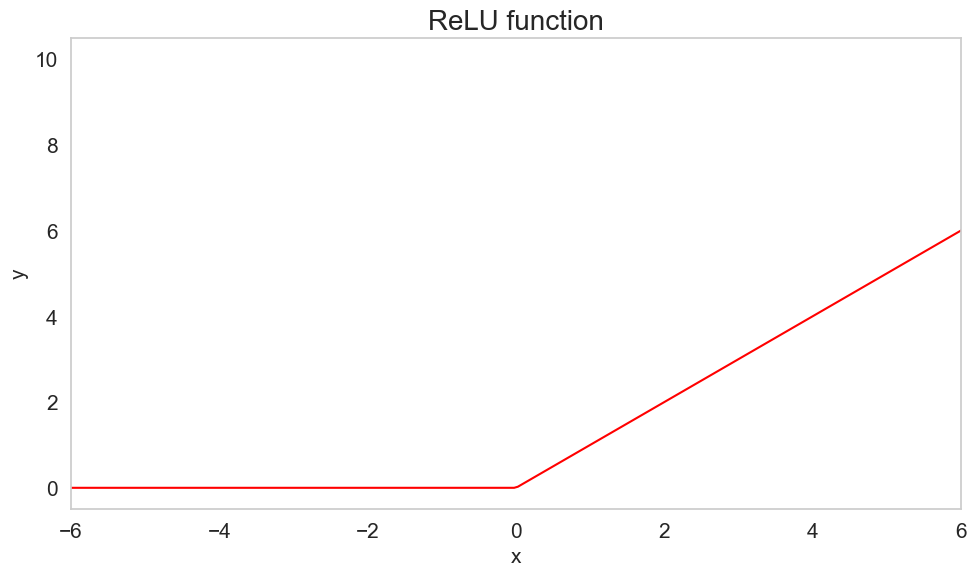

In [183]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

x = np.linspace(-10, 10, 400)

y_sigmoid = sigmoid(x)
y_relu = relu(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y_relu, label="ReLU", color='r')
plt.title("ReLU function", fontsize=20)
plt.xlabel("x",fontsize=15)
plt.ylabel("y",fontsize=15)
plt.grid(False)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.xlim(-6, 6)
plt.tight_layout()
plt.savefig("2_relu_function.png", format="png", dpi=200, bbox_inches='tight', transparent=True)



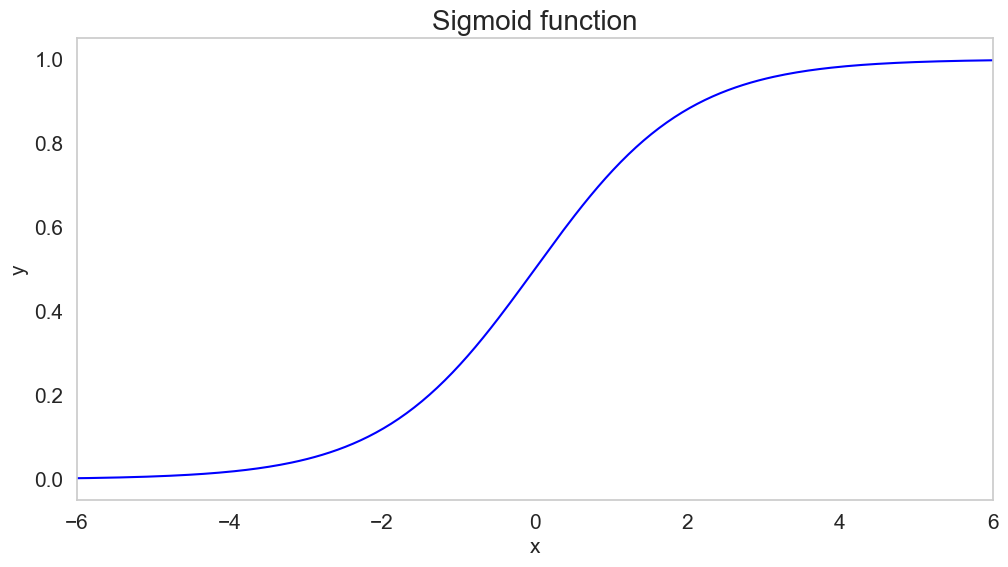

In [184]:
plt.figure(figsize=(26, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y_sigmoid, label="Sigmoid", color='b')
plt.title("Sigmoid function", fontsize=20)
plt.xlabel("x",fontsize = 15)
plt.ylabel("y",fontsize=15)
plt.grid(False)
plt.xlim(-6, 6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("2_sigmoid_function.png", format="png", dpi=200, bbox_inches='tight', transparent=True)


### 3.2 Figure 2.4 -  Examples of applying the SVM algorithm

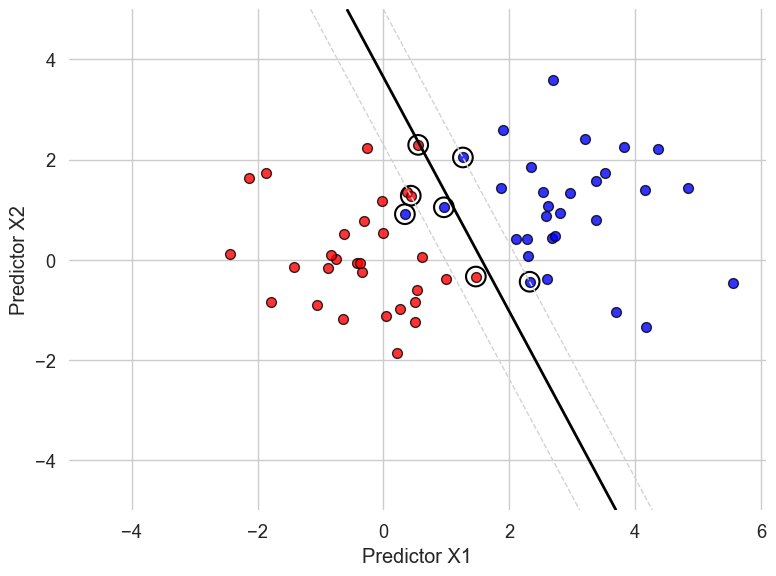

In [185]:
np.random.seed(2)
class_a = np.random.randn(30, 2)
class_b = np.random.randn(30, 2) + [3, 1]  
X = np.vstack((class_a, class_b))
y = np.array([0] * 30 + [1] * 30)  

clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

xx = np.linspace(-5, 5, 100)
yy = np.linspace(-5, 5, 100)
XX, YY = np.meshgrid(xx, yy)
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

plt.figure(figsize=(8, 6), facecolor='white')

plt.contour(XX, YY, Z, levels=[-1, 0, 1],
            colors=['lightgray', 'black', 'lightgray'],
            linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', s=50, edgecolors='k', alpha=0.8)  
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', s=50, edgecolors='k', alpha=0.8)  

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            facecolors='none', s=200, edgecolors='black', linewidths=1.5,color='black')


plt.xlabel("Predictor X1")
plt.ylabel("Predictor X2")
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()

plt.savefig("2_svm_example_2.png", format="png", dpi=200, bbox_inches='tight', transparent=True)


plt.show()

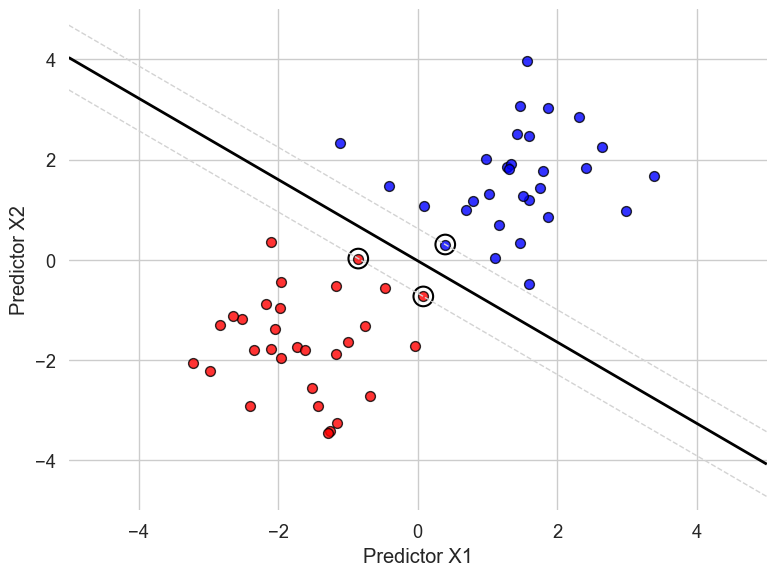

In [186]:
np.random.seed(42)
class_a = np.random.randn(30, 2) - [1.5, 1.5]  
class_b = np.random.randn(30, 2) + [1.5, 1.5]  
X = np.vstack((class_a, class_b))
y = np.array([0] * 30 + [1] * 30)  

clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

xx = np.linspace(-5, 5, 100)
yy = np.linspace(-5, 5, 100)
XX, YY = np.meshgrid(xx, yy)
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

plt.figure(figsize=(8, 6), facecolor='white')

plt.contour(XX, YY, Z, levels=[-1, 0, 1],
            colors=['lightgray', 'black', 'lightgray'],
            linestyles=['--', '-', '--'], linewidths=[1, 2, 1])

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', s=50, edgecolors='k', alpha=0.8)  
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', s=50, edgecolors='k', alpha=0.8)  

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            facecolors='none', s=200, edgecolors='black', linewidths=1.5,color='black')


plt.xlabel("Predictor X1")
plt.ylabel("Predictor X2")
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()

plt.savefig("2_svm_example_1.png", format="png", dpi=200, bbox_inches='tight', transparent=True)


plt.show()

### 3.3 Figure 2.5 - An example of applying the KNN algorithm

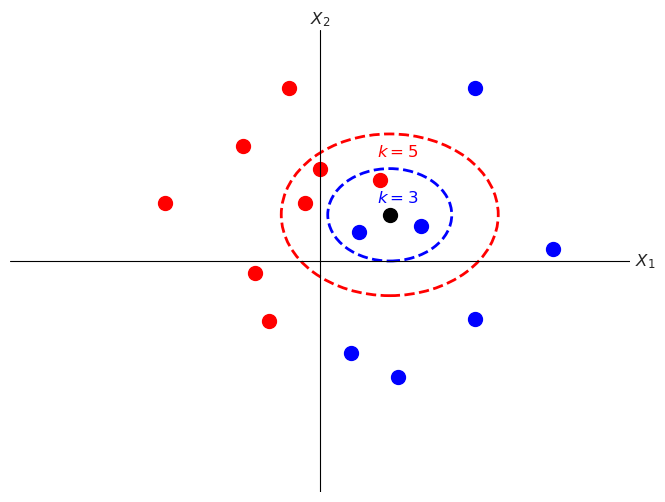

In [187]:
plt.figure(figsize=(8, 6), facecolor='white')

plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(0, color='black', linewidth=0.8)

plt.text(2.1, 0, r'$X_1$', fontsize=12, ha='center', va='center')
plt.text(0, 2.1, r'$X_2$', fontsize=12, ha='center', va='center')

plt.scatter([-1, -0.5, 0,0.39,-0.1,-0.2,-0.33,-0.42], [0.5, 1, 0.8,0.7,0.5,1.5,-0.52,-0.1], color='red', s=100)
plt.scatter([1, 0.5, 0.20,0.25,0.65,1,1.5], [-0.5, -1, -0.8,0.25,0.3,1.5,0.1], color='blue', s=100)
plt.scatter([0.45], [0.4], color='black', s=100, label='Classe B')

plt.text(0.5, 0.55, r'$k = 3$', fontsize=12, ha='center', va='center', color='blue')
plt.text(0.5, 0.95, r'$k = 5$', fontsize=12, ha='center', va='center', color='red')

circle = plt.Circle([0.45,0.4], radius=0.4, color='blue', fill=False, linestyle='--', linewidth=2)
plt.gca().add_patch(circle)
circle = plt.Circle([0.45,0.4], radius=0.7, color='red', fill=False, linestyle='--', linewidth=2)
plt.gca().add_patch(circle)

plt.xticks([])
plt.yticks([])
plt.box(False)

plt.savefig("2_knn_example.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()

### 3.4 Figure 2.8 - Example of a ROC curve 

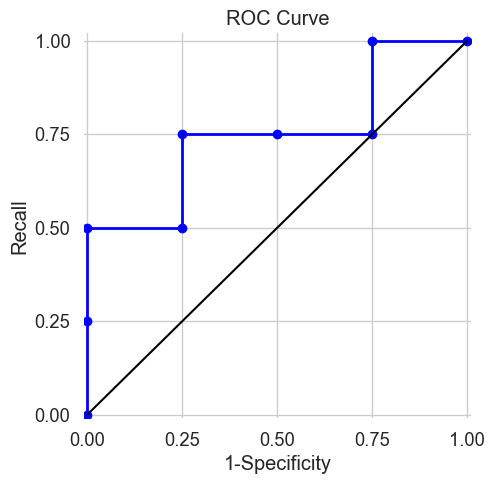

In [188]:
fpr = [0.0, 0.0, 0.0, 0.25, 0.25, 0.5, 0.75, 0.75, 1.0]
tpr = [0.0, 0.25, 0.5, 0.50, 0.75, 0.75, 0.75, 1.0, 1.0]

plt.figure(figsize=(5, 5))
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.02)
plt.plot(fpr, tpr, marker='o', color='blue', linestyle='-', linewidth=2)  
plt.plot([0, 1], [0, 1], color='black', linestyle='-') 

plt.xlabel("1-Specificity")
plt.ylabel("Recall")
plt.title("ROC Curve")
plt.grid(True)

plt.xticks(np.arange(0, 1.25, 0.25))
plt.yticks(np.arange(0, 1.25, 0.25))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.savefig("2_roc_example.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()


# 4. Figures to metdology chapter

### 4.1 Figure 4.1 - Distribution of number of classes in OpenML-CC18

In [63]:
suite = openml.study.get_suite(99)
task_ids = suite.tasks
class_counts = []
for i in task_ids:
    task = openml.tasks.get_task(i)
    class_counts.append(len(task.class_labels))

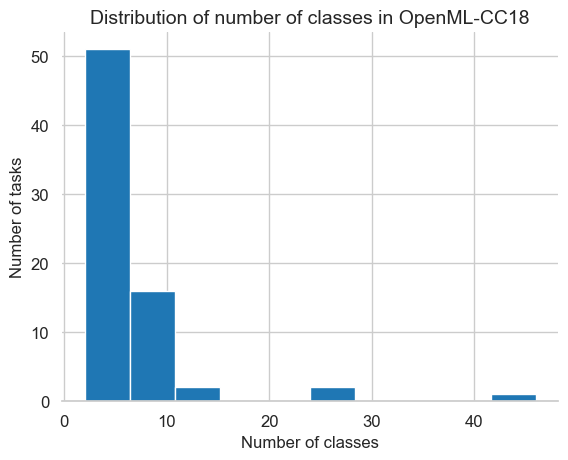

In [189]:
sns.set_style("whitegrid")
sns.histplot(class_counts, bins=10, alpha=1)
plt.xlabel('Number of classes',fontsize=12)
plt.ylabel('Number of tasks', fontsize=12)
plt.title('Distribution of number of classes in OpenML-CC18',fontdict={'fontsize': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig("4_hist_class_per_task.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()

### 4.2 Fugire 4.2 - Distribution of runs across tasks in OpenML-CC18

In [14]:
function = "area_under_roc_curve"
tasks = tasks_id 
output_format = "dataframe"
evaluations_per_task = []
openml.config.limit = None

for task_id in tasks:
    offset = 0
    chunk_size = 10000  
    all_evaluations = []
    
    while True:
        evaluations_chunk = openml.evaluations.list_evaluations(
            function=function,
            tasks=[task_id],
            output_format=output_format,
            offset=offset,
            size=chunk_size
        )
        
        all_evaluations.append(evaluations_chunk)     
        offset += chunk_size
        if len(evaluations_chunk) < chunk_size:
            break
    
    evaluations_per_task.append(pd.concat(all_evaluations, ignore_index=True))

In [15]:
unique_model_counts_per_task = []
runs_counts_per_task = []
for i in range(len(evaluations_per_task)):
    unique_model_counts_per_task.append(evaluations_per_task[i]['flow_id'].nunique())
    runs_counts_per_task.append(len(evaluations_per_task[i]['flow_id']))

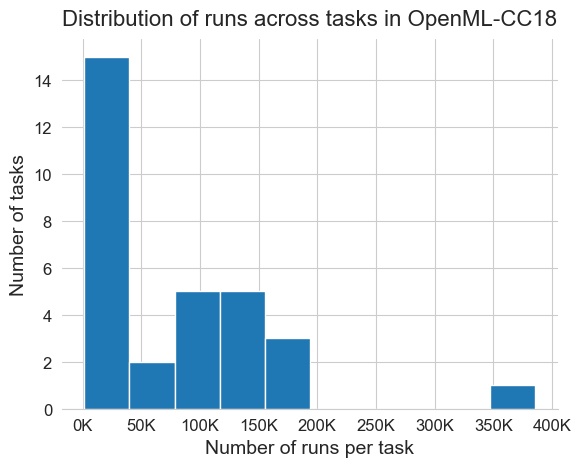

In [17]:
figsize=(6.4, 4.8)
plt.figure(figsize=figsize)
sns.set_style("whitegrid")
sns.histplot(runs_counts_per_task, bins=10, alpha=1)
plt.xlabel('Number of runs per task',fontsize=14)
plt.ylabel('Number of tasks', fontsize=14)
plt.title('Distribution of runs across tasks in OpenML-CC18',fontdict={'fontsize': 16}, pad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

y_min, y_max = plt.ylim()
x_min, x_max = plt.xlim()
plt.xticks(range(0, int(x_max) + 1, 50000))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000):,}K'))

#plt.savefig("4_hist_runs_per_task.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

### 4.3 Figure 4.3 - Distribution of flows across tasks in OpenML-CC18

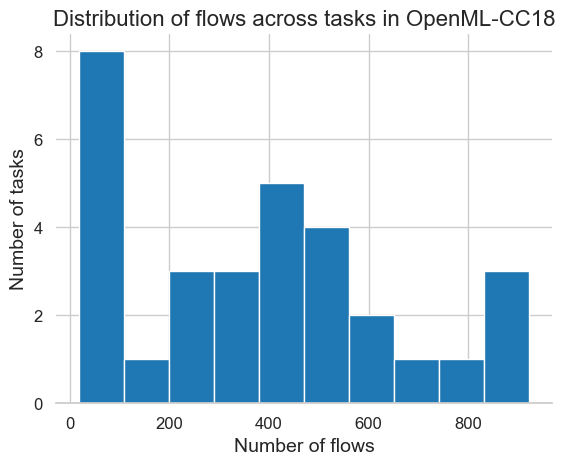

In [191]:
figsize=(6.4, 4.8)
plt.figure(figsize=figsize)
sns.set_style("whitegrid")
sns.histplot(unique_model_counts_per_task, bins=10, alpha=1)
plt.xlabel('Number of flows',fontsize=14)
plt.ylabel('Number of tasks', fontsize=14)
plt.title('Distribution of flows across tasks in OpenML-CC18',fontdict={'fontsize': 16})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

y_min, y_max = plt.ylim()
plt.yticks(range(int(y_min), int(y_max) + 1, 2))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig("4_hist_flows_per_task.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()

### 4.4 Figure 4.4 - Distribution of Flow Occurrences in Algorithms

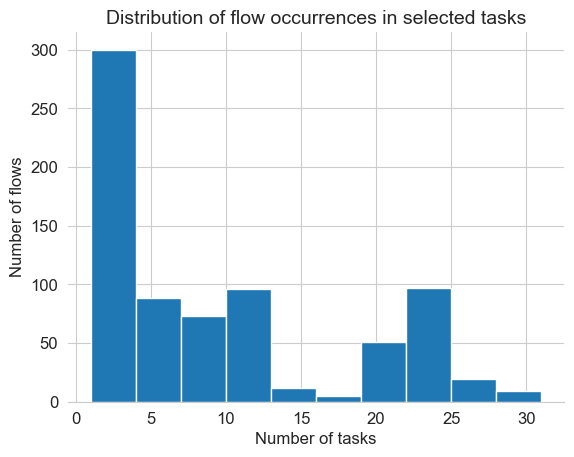

In [11]:
new = counts.drop('flow_id',axis=1)
sns.set_style("whitegrid")
sns.histplot(new, color='red',bins=10, alpha=1, legend=False)
plt.xlabel('Number of tasks',fontsize=12)
plt.ylabel('Number of flows', fontsize=12)
plt.title('Distribution of flow occurrences in selected tasks',fontdict={'fontsize': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


#plt.savefig("4_hist_flow_in_tasks.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

### 4.5 Figure 4.5 - Matrix of result fill-in at the flows level

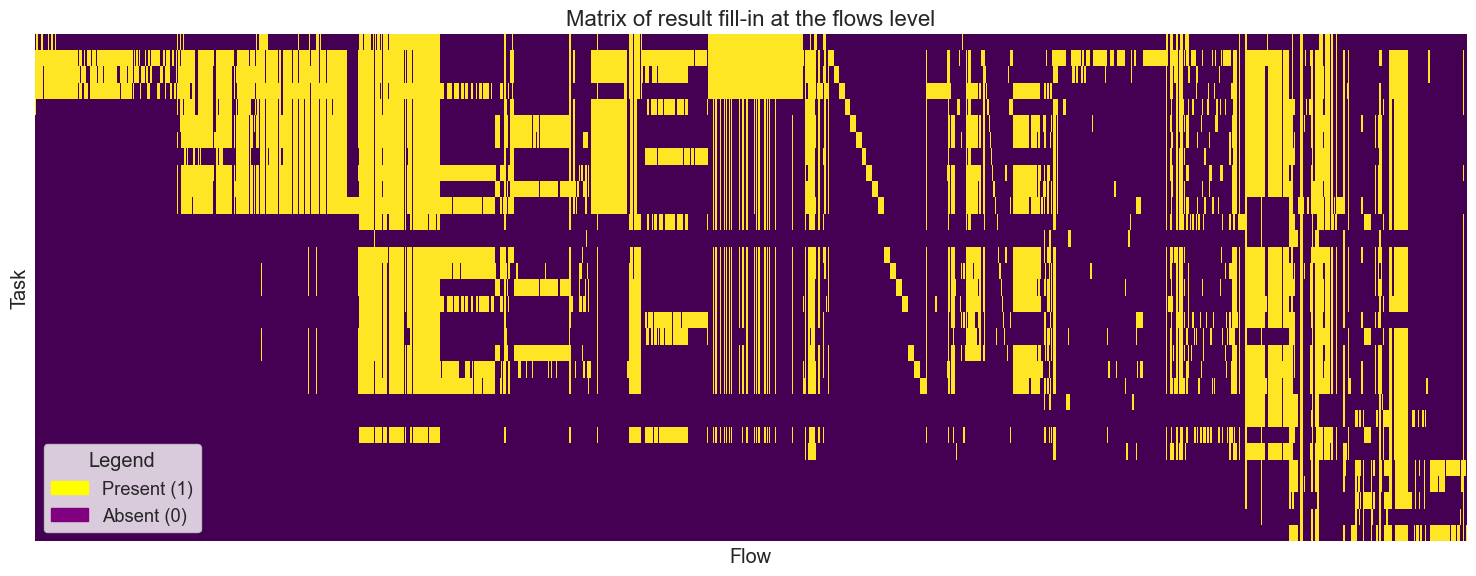

In [193]:
all_players = set()
for df in epp_score:
    all_players.update(df['flow_id'].unique())

all_players = sorted(list(all_players))


presence_matrix = pd.DataFrame(0, index=range(len(epp_score)), columns=all_players)

for i, df in enumerate(epp_score):
    present_players = df['flow_id'].unique()
    presence_matrix.loc[i, present_players] = 1

plt.figure(figsize=(15, 6))
sns.heatmap(presence_matrix,cmap='viridis',cbar=False)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.xlabel("Flow")
plt.ylabel("Task")
plt.title("Matrix of result fill-in at the flows level", fontdict={'fontsize': 16})
legend_labels = [
    mpatches.Patch(color='yellow', label='Present (1)'),
    mpatches.Patch(color='purple', label='Absent (0)')
]
plt.legend(handles=legend_labels, loc='lower left', title='Legend')
plt.tight_layout()

plt.savefig("4_fill_matrix_flow.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

### 4.6 Figure 4.6 - Matrix of result fill-in at the best flows level

In [11]:
player_names = counts.loc[:,['flow_id', 'model_name']].dropna()

epp_score_names = [None] * len(epp_score)
for i in range(len(epp_score)):
    epp_score_names[i] = pd.merge(epp_score[i], player_names[['flow_id', 'model_name']], on='flow_id', how='left').dropna()

epp_score_names_best = [None] * len(epp_score)
for i in range(len(epp_score_names)):
    epp_score_names_best[i] = epp_score_names[i].groupby('model_name')['epp'].max().reset_index()

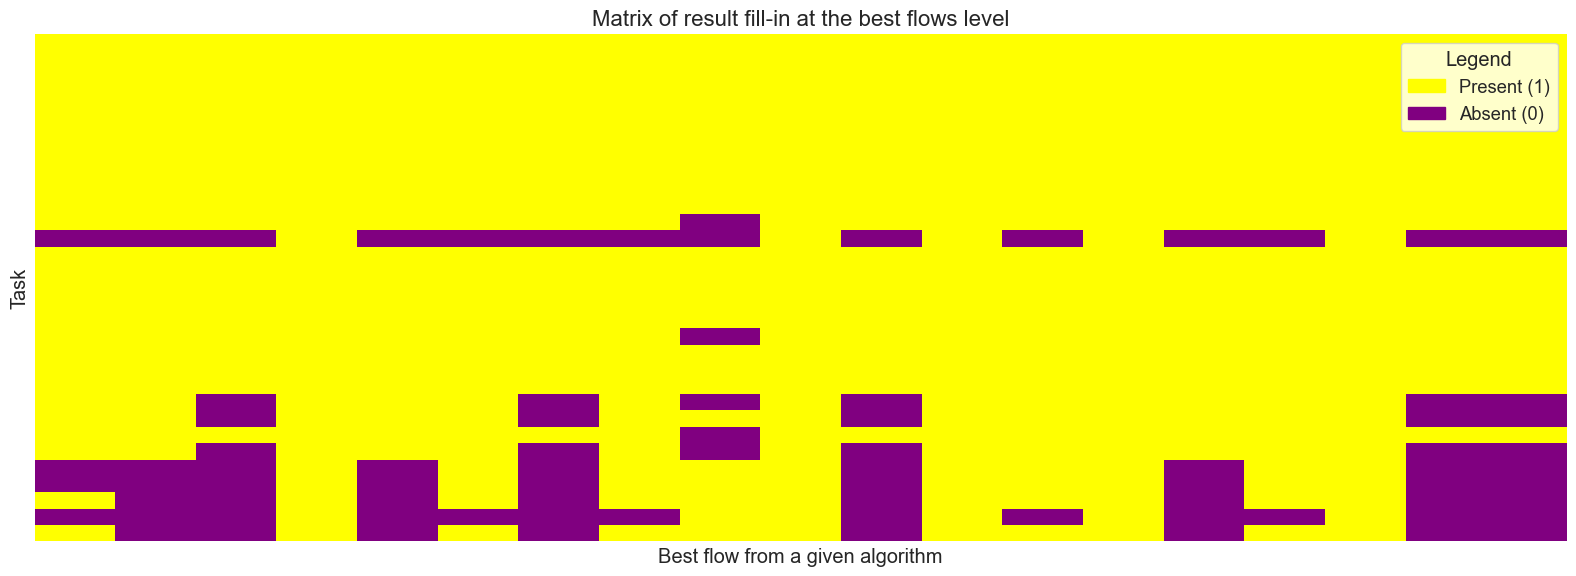

In [194]:
all_models = set()
for df in epp_score_names_best:
    all_models.update(df['model_name'].unique())

all_models = sorted(list(all_models))  

presence_matrix_models = pd.DataFrame(0, index=range(len(epp_score_names_best)), columns=all_models)

for i, df in enumerate(epp_score_names_best):
    present_models = df['model_name'].unique()
    presence_matrix_models.loc[i, present_models] = 1

cmap = ListedColormap(['purple', 'yellow']) 

plt.figure(figsize=(16, 6))
sns.heatmap(presence_matrix_models, cmap=cmap, cbar=False)

# Dodaj legendę
legend_labels = [
    mpatches.Patch(color='yellow', label='Present (1)'),
    mpatches.Patch(color='purple', label='Absent (0)')
]
plt.legend(handles=legend_labels, loc='upper right', title='Legend')

plt.xlabel("Best flow from a given algorithm")
plt.ylabel("Task")
plt.title("Matrix of result fill-in at the best flows level", fontsize=16)

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig("4_fill_matrix_best_flow.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

### 4.7 Figure 4.7 - Flow Count in Algorithms

In [102]:
zbior = extract_algorithm(counts, ['sklearn','weka'],dropna=True)['model_name'].value_counts()

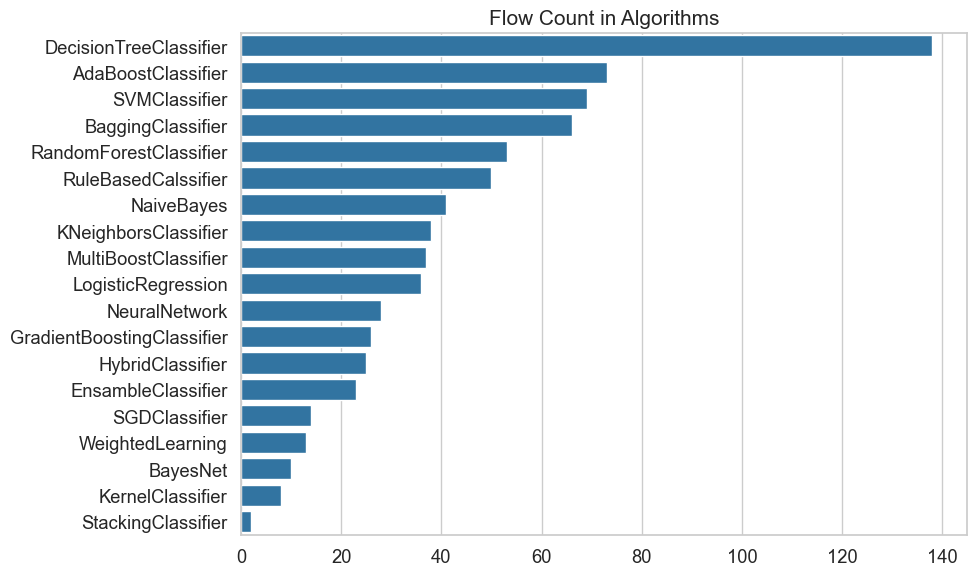

In [197]:
plt.figure(figsize=(10, 6))
sns.barplot(y=zbior.index, x=zbior.values, color='C0')
sns.set_style("whitegrid")
plt.xlabel('')
plt.title('Flow Count in Algorithms', fontdict={'fontsize': 15})
plt.tight_layout()

#plt.savefig("4_algorithm_counts.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

# 5. Figures to Experiment Results chapter

### 5.1 Probability matrix

In [115]:
win_proba = []

for i in range(len(epp_score_names_best)):
    model_names = epp_score_names_best[i]['model_name'].values
    epp_values = epp_score_names_best[i].set_index('model_name')['epp'].values
    diff_matrix = epp_values[:, None] - epp_values
    proba_matrix = np.exp(diff_matrix) / (1 + np.exp(diff_matrix))
    win_proba.append(pd.DataFrame(proba_matrix, columns=model_names, index=model_names)) 

#### 5.1.1 Figure 5.1 - Probability matrix for task ID 49

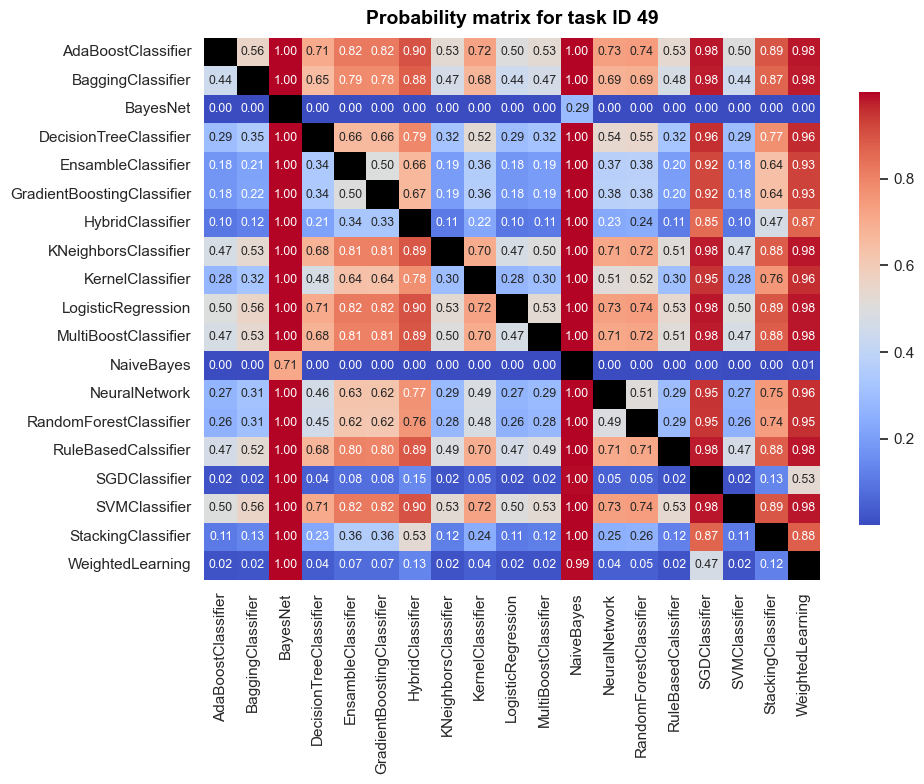

In [198]:
win_proba[3]
n = win_proba[3].shape[0]
mask_main = np.eye(n, dtype=bool)
mask_diag = ~mask_main

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    win_proba[3],
    mask=mask_main,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    annot_kws={"size": 8.9},
    cbar_kws={"shrink": .8},
    ax=ax
)
sns.heatmap(
    win_proba[3],
    mask=mask_diag,
    cmap=['black'],    
    cbar=False,         
    ax=ax
)
ax.set_title(
    'Probability matrix for task ID 49',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)

plt.tight_layout()
plt.savefig("5_prob_matrix_49.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

#### 5.1.2 Figure 5.2 - Probability matrix for task ID 7592

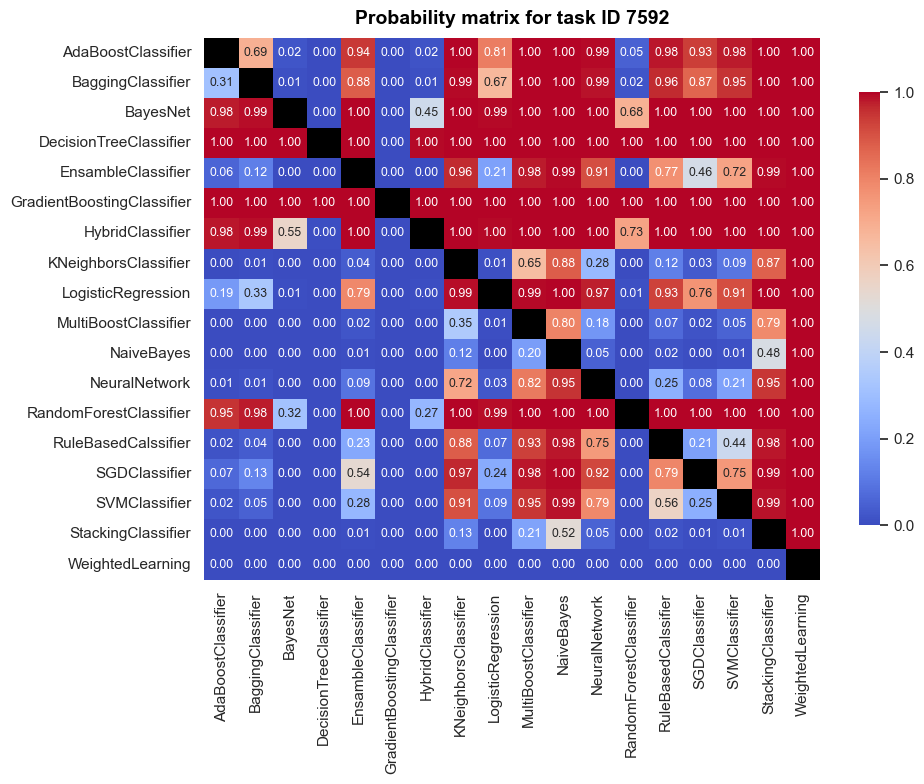

In [199]:
win_proba[11]
n = win_proba[11].shape[0]
mask_main = np.eye(n, dtype=bool)
mask_diag = ~mask_main

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    win_proba[11],
    mask=mask_main,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    annot_kws={"size": 8.9},
    cbar_kws={"shrink": .8},
    ax=ax
)
sns.heatmap(
    win_proba[11],
    mask=mask_diag,
    cmap=['black'],    
    cbar=False,         
    ax=ax
)
ax.set_title(
    'Probability matrix for task ID 7592',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)

plt.tight_layout()
plt.savefig("5_prob_matrix_7592.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

### 5.2 EPP vs AUC

In [12]:
epp_auc = [df.copy(deep=True) for df in epp_score_names]
for i in range(len(epp_score)):
    epp_auc[i]['flow_id'] = pd.to_numeric(epp_auc[i]['flow_id'])
    epp_auc[i]['epp'] = pd.to_numeric(epp_auc[i]['epp'])
    epp_auc[i]['p_value'] = pd.to_numeric(epp_auc[i]['p_value'])

for i in range(len(tasks_id)):
    evaluations = openml.evaluations.list_evaluations(
        function="area_under_roc_curve",
        tasks=[tasks_id[i]],
        output_format="dataframe"
    ).drop_duplicates(subset='flow_id')

    epp_auc[i]['auc'] = epp_auc[i]['flow_id'].map(
        evaluations.set_index('flow_id')['value']
    )

### 5.2.1 Figure 5.3 - EPP vs AUC task 9971

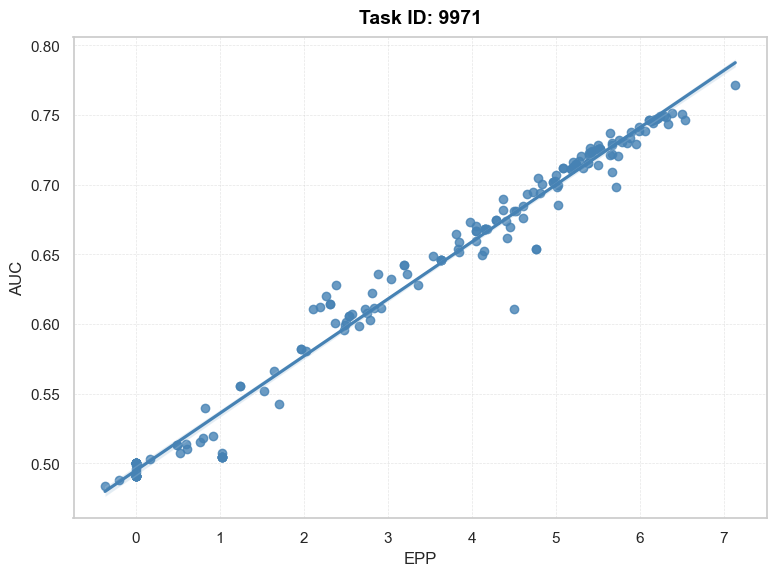

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

df = epp_auc[16]

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(
    data=df,
    x='epp',
    y='auc',
    ax=ax,
    color='steelblue',     
)

ax.set_title(
    f'Task ID: {tasks_id[16]}',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', labelsize=11)

ax.legend().remove()

plt.tight_layout()

#plt.savefig("5_epp_vs_auc_9971.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()


### 5.2.2 Figure 5.4 - EPP vs AUC task 3021

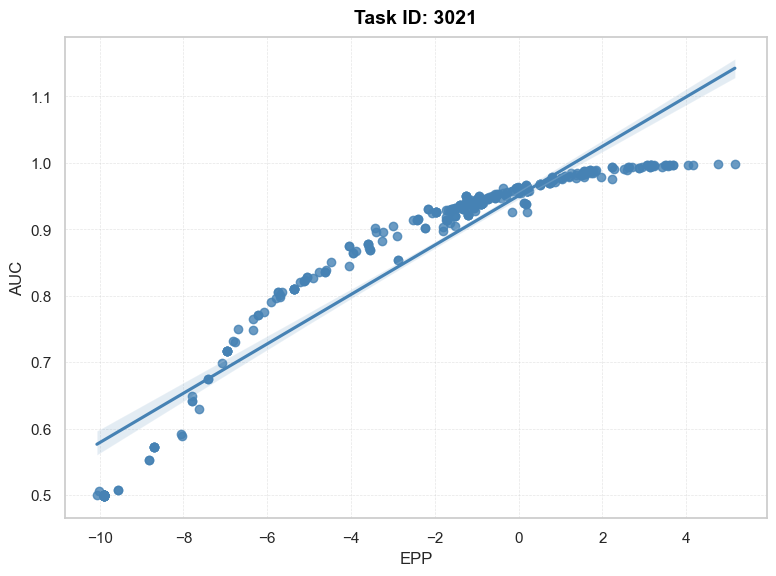

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

df = epp_auc[4]

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(
    data=df,
    x='epp',
    y='auc',
    ax=ax,
    color='steelblue',     
)

ax.set_title(
    f'Task ID: {tasks_id[4]}',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', labelsize=11)

ax.legend().remove()

plt.tight_layout()

#plt.savefig("5_epp_vs_auc_3021.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()


### 5.2.3 Figure 5.5 - EPP vs AUC task 9946

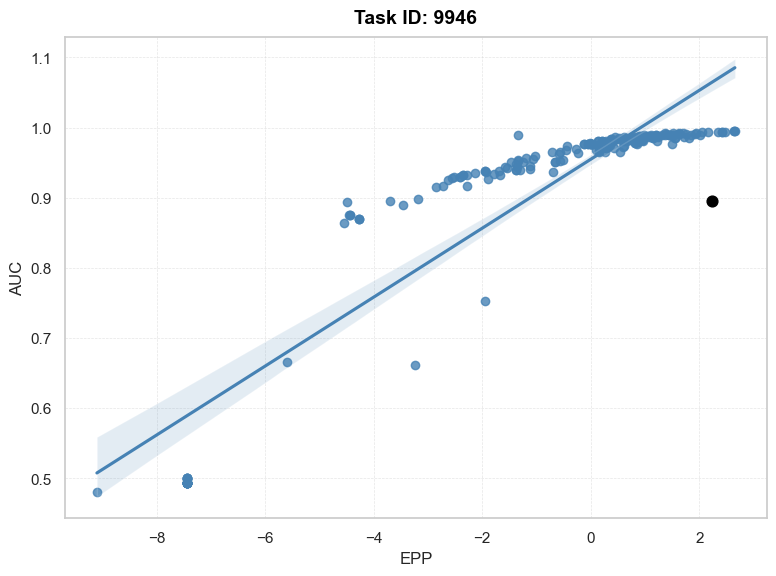

In [83]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

df = epp_auc[13]

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(
    data=df,
    x='epp',
    y='auc',
    ax=ax,
    color='steelblue',     
)

highlight = df[(df['epp'] > 2) & (df['auc'] < 0.9)]

ax.scatter(
    highlight['epp'],
    highlight['auc'],
    color='black',
    s=60,
    label='epp > 2 & auc < 0.9',
    zorder=5
)

ax.set_title(
    f'Task ID: {tasks_id[13]}',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', labelsize=11)

ax.legend().remove()

plt.tight_layout()

#plt.savefig("5_epp_vs_auc_9946.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

### 5.3 EPP vs RECALL

In [17]:
epp_acc = [df.copy(deep=True) for df in epp_score_names]
for i in range(len(epp_score)):
    epp_acc[i]['flow_id'] = pd.to_numeric(epp_acc[i]['flow_id'])
    epp_acc[i]['epp'] = pd.to_numeric(epp_acc[i]['epp'])
    epp_acc[i]['p_value'] = pd.to_numeric(epp_acc[i]['p_value'])

for i in range(len(tasks_id)):
    evaluations = openml.evaluations.list_evaluations(
        function="recall",
        tasks=[tasks_id[i]],
        output_format="dataframe"
    ).drop_duplicates(subset='flow_id')

    epp_acc[i]['recall'] = epp_acc[i]['flow_id'].map(
        evaluations.set_index('flow_id')['value']
    )

### 5.3.1 Figure 5.6 - EPP vs RECALL task 3021

### 5.3.1 Figure 5.7 - EPP vs RECALL task 9957

In [ ]:
for licz in tasks_id:
    task_id_filter = licz
    all_results = []
    
    # download only metadata
    flows = openml.evaluations.list_evaluations(
        function="recall",
        tasks=[task_id_filter],
        output_format="dataframe",
        size=page_size,
        per_fold=False  
    )['flow_id'].unique()

    for flow_id in flows:
        # download only one row for given flow_id
        evaluation = openml.evaluations.list_evaluations(
            function="recall",
            tasks=[task_id_filter],
            flows=[flow_id],
            output_format="dataframe",
            offset=0,
            size=1,  
            per_fold=True
        )

        if not evaluation.empty:
            all_results.append(evaluation)

    # aggregate results
    wyniki_i = pd.concat(all_results, ignore_index=True)

    rows = []
    for _, row in wyniki_i.iterrows():
        flow_id = row['flow_id']
        values = row['values']
        for i, value in enumerate(values):
            rows.append({'player': flow_id, 'round': i + 1, 'score': value})

    ostateczne_wyniki = pd.DataFrame(rows)
    all_final_results.append(ostateczne_wyniki)

In [ ]:
 # Calcuate EPP for all tasks
for i in range(len(all_final_results)):
    epp_recall.append(calculate_epp_leaderboard(all_final_results[i]))

In [ ]:
for i in range(len(epp_recall)):
    epp_recall[i]['flow_id'] = pd.to_numeric(epp_recall[i]['flow_id'])
    epp_recall[i]['epp'] = pd.to_numeric(epp_recall[i]['epp'])
    epp_recall[i]['p_value'] = pd.to_numeric(epp_recall[i]['p_value'])

for i in range(len(tasks_id)):
    evaluations = openml.evaluations.list_evaluations(
        function="recall",
        tasks=[tasks_id[i]],
        output_format="dataframe"
    ).drop_duplicates(subset='flow_id')

    epp_recall[i]['recall'] = epp_recall[i]['player'].map(
        evaluations.set_index('flow_id')['value']
    )

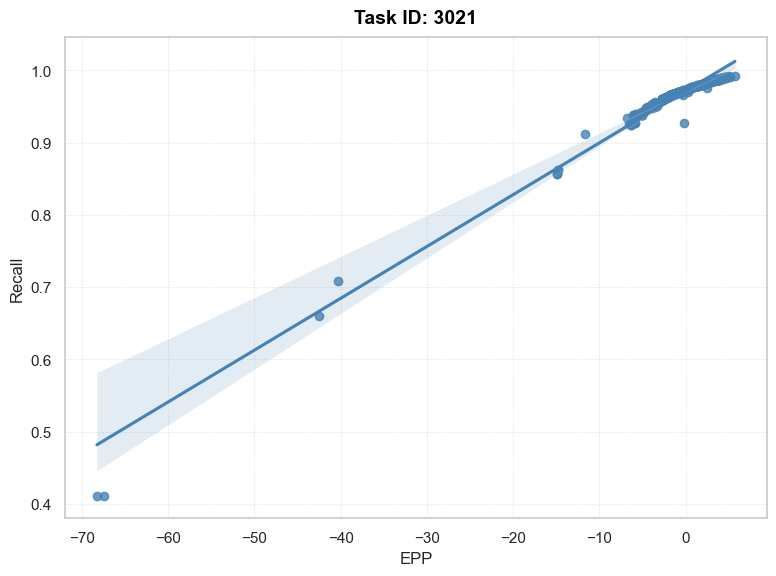

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

i = 4  
df = epp_recall[i]

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(
    data=df,
    x='epp',
    y='recall',
    ax=ax,
    color='steelblue',     
)

ax.set_title(
    f'Task ID: {tasks_id[i]}',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', labelsize=11)

ax.legend().remove()

plt.tight_layout()

#plt.savefig("5_epp_vs_recall_3021.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()


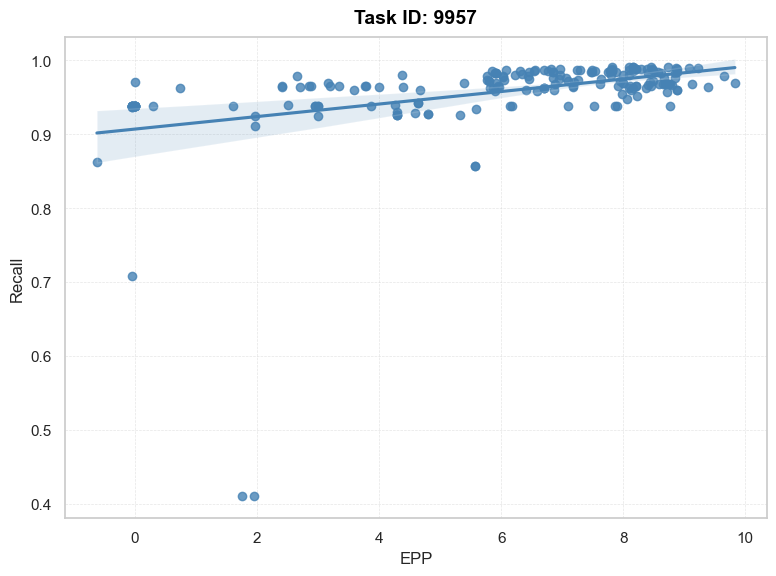

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

i = 15  
df = epp_recall[i]

fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(
    data=df,
    x='epp',
    y='recall',
    ax=ax,
    color='steelblue',     
)

ax.set_title(
    f'Task ID: {tasks_id[i]}',
    fontsize=14,
    fontweight='bold',
    pad=10,
    loc='center',
    color='black'
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.tick_params(axis='both', labelsize=11)

ax.legend().remove()

plt.tight_layout()

#plt.savefig("5_epp_vs_recall_9957.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()


# 5.4 EPP values distributions for algorithms across tasks

In [149]:
bayes_center_epp = [df.copy(deep=True) for df in epp_score_names]
for i in range(len(epp_score)):
    bayes_score = epp_score_names[i][epp_score_names[i]['flow_id'] == 8456]['epp'].values[0]
    bayes_center_epp[i]['epp'] = epp_score_names[i]['epp'] - bayes_score

### 5.4.1 Figure 5.8 Boxplot of EPP values for each algorithm for task number 3918

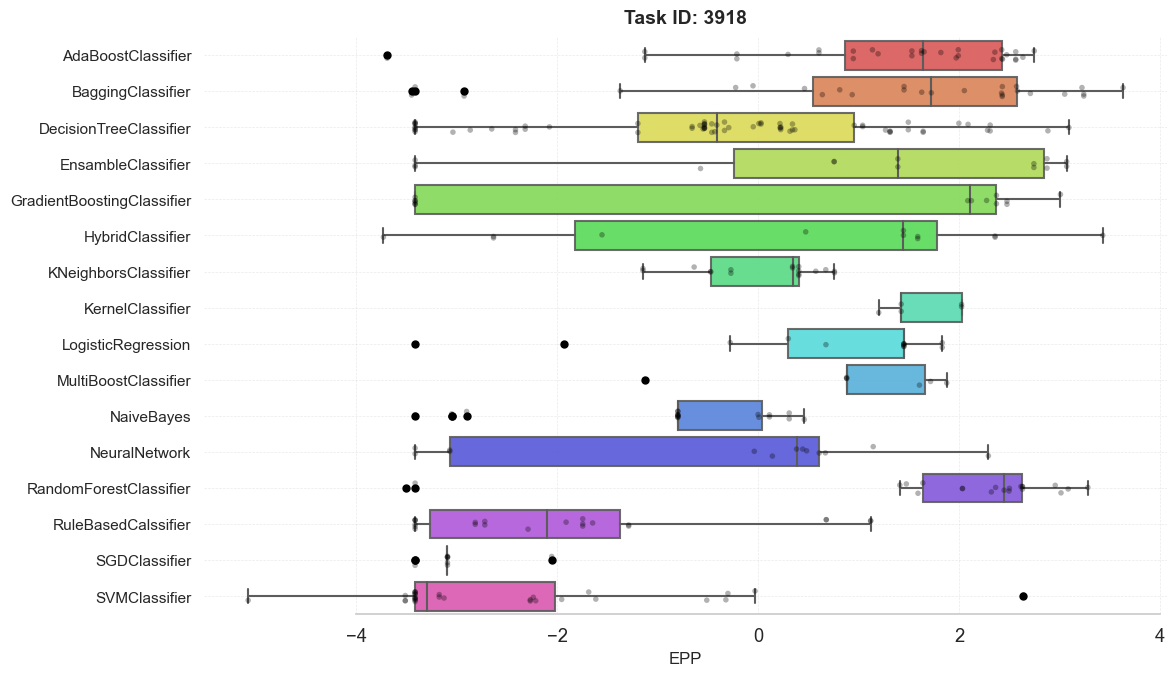

In [ ]:
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

threshold = 4
i = 10  

all_models = set()
for df in bayes_center_epp:
    vc = df['model_name'].value_counts()
    keep = vc[vc > threshold].index.tolist()
    all_models.update(keep)
all_models = sorted(all_models)

n_colors = len(all_models)
palette_colors = [
    colorsys.hls_to_rgb(i / n_colors, 0.6, 0.85) 
    for i in range(n_colors)
]
global_palette = dict(zip(all_models, palette_colors))

df = bayes_center_epp[i]
vc = df['model_name'].value_counts()
keep = vc[vc > threshold].index
filtered_df = df[df['model_name'].isin(keep)]

order = [m for m in all_models if m in keep]

fig, ax = plt.subplots(figsize=(12, 7))

sns.boxplot(
    y='model_name',
    x='epp',
    data=filtered_df,
    ax=ax,
    palette=global_palette,
    order=order,
    orient="h",
    linewidth=1.5,
    boxprops=dict(alpha=0.9),
    fliersize=5,  
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'black',  
        'markeredgecolor': 'black',
        'alpha': 1.0
    },
)

sns.stripplot(
    y='model_name',
    x='epp',
    data=filtered_df,
    ax=ax,
    order=order,
    orient="h",
    jitter=0.15,
    size=4,
    alpha=0.3,
    color='black'
)

ax.set_title(
    f'Task ID: {tasks_id[i]}',
    fontsize=14,
    fontweight='bold',
    loc='center',
    pad=10
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
sns.despine(trim=True, left=True, bottom=False)

handles = [
    plt.Line2D([0], [0], marker='s', linestyle='', markersize=10, color=global_palette[model], label=model)
    for model in order
]


plt.tight_layout()
#plt.savefig("5_boxplot_task_3918.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()

### 5.4.2 Figure 5.9 Boxplot of EPP values for each algorithm for task number 9977

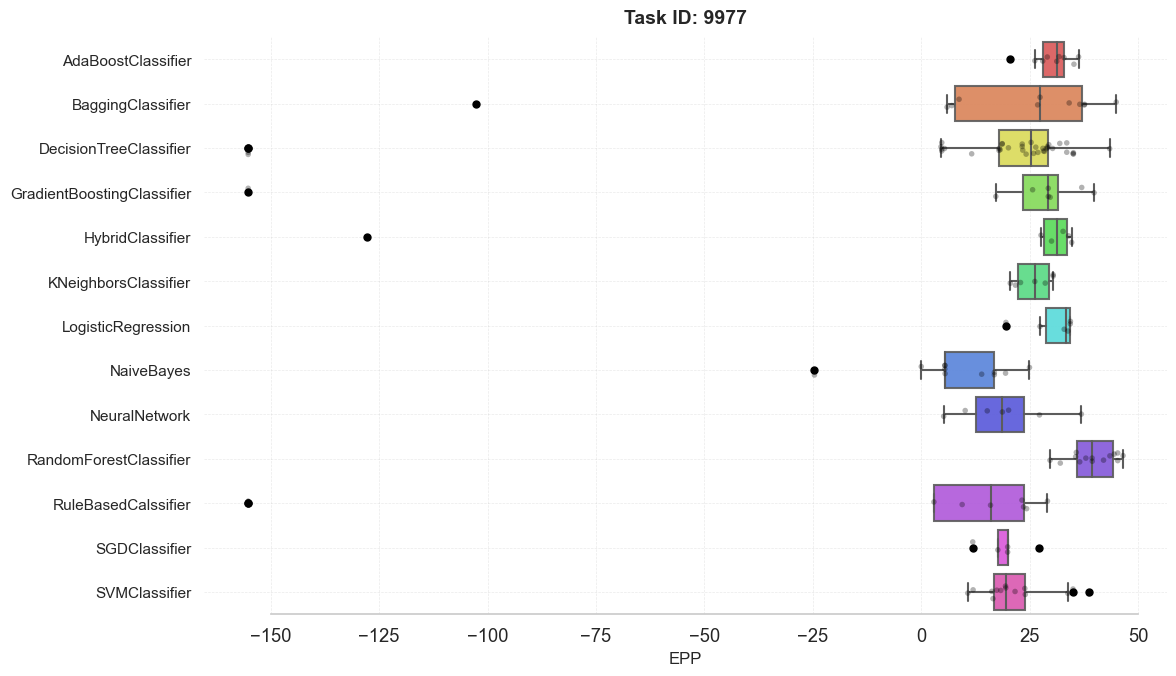

In [ ]:
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

threshold = 4
i = 18 

all_models = set()
for df in bayes_center_epp:
    vc = df['model_name'].value_counts()
    keep = vc[vc > threshold].index.tolist()
    all_models.update(keep)
all_models = sorted(all_models)

n_colors = len(all_models)
palette_colors = [
    colorsys.hls_to_rgb(i / n_colors, 0.6, 0.85) 
    for i in range(n_colors)
]
global_palette = dict(zip(all_models, palette_colors))

df = bayes_center_epp[i]
vc = df['model_name'].value_counts()
keep = vc[vc > threshold].index
filtered_df = df[df['model_name'].isin(keep)]

order = [m for m in all_models if m in keep]

fig, ax = plt.subplots(figsize=(12, 7))

sns.boxplot(
    y='model_name',
    x='epp',
    data=filtered_df,
    ax=ax,
    palette=global_palette,
    order=order,
    orient="h",
    linewidth=1.5,
    boxprops=dict(alpha=0.9),
    fliersize=5,  
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'black',  
        'markeredgecolor': 'black',
        'alpha': 1.0
    },
)

sns.stripplot(
    y='model_name',
    x='epp',
    data=filtered_df,
    ax=ax,
    order=order,
    orient="h",
    jitter=0.15,
    size=4,
    alpha=0.3,
    color='black'
)

ax.set_title(
    f'Task ID: {tasks_id[i]}',
    fontsize=14,
    fontweight='bold',
    loc='center',
    pad=10
)
ax.set_xlabel('EPP', fontsize=12)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
sns.despine(trim=True, left=True, bottom=False)

handles = [
    plt.Line2D([0], [0], marker='s', linestyle='', markersize=10, color=global_palette[model], label=model)
    for model in order
]


plt.tight_layout()
#plt.savefig("5_boxplot_task_9977.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()

# 5.5 Comparison of best flow performance Distributions

In [156]:
epp_score_names_best_bayes = [None] * len(epp_score)
for i in range(len(epp_score_names)):
    epp_score_names_best_bayes[i] = bayes_center_epp[i].groupby('model_name')['epp'].max().reset_index()

### 5.5.1 Figure 5.10 Boxplot of values for the best flows of each algorithm, divided by tasks

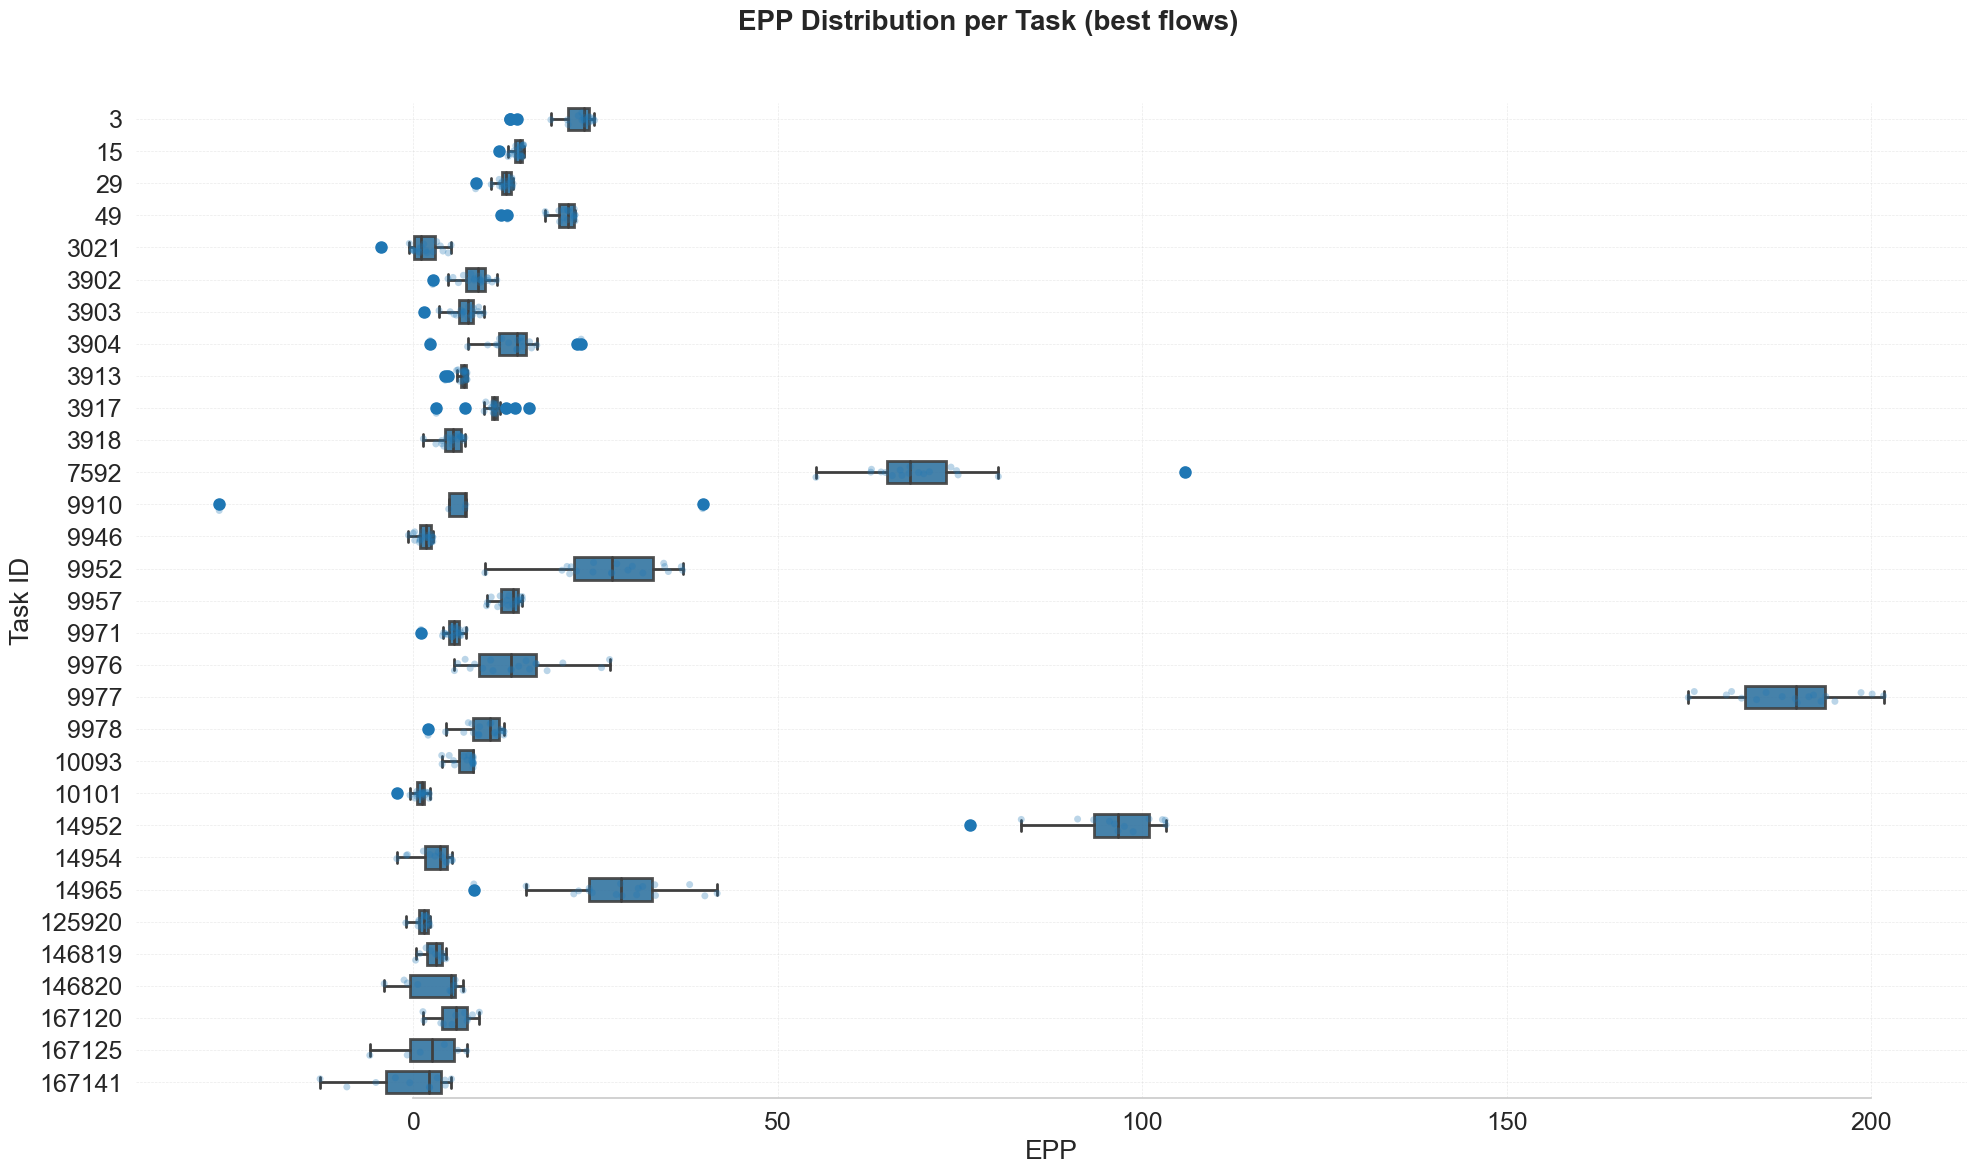

In [ ]:
df_list = []
for k, df_orig in enumerate(epp_score_names_best):
    df = df_orig[['epp']].copy()
    df['task'] = str(tasks_id[k])
    df_list.append(df)
df_all = pd.concat(df_list, ignore_index=True)

tasks = sorted(df_all['task'].unique(), key=lambda x: int(x))

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)


fig, ax = plt.subplots(figsize=(20, 12))

sns.boxplot(
    data=df_all,
    y='task',
    x='epp',
    order=tasks,
    color='C0',
    width=0.7,
    linewidth=2.0,
    showfliers=True,
    fliersize=8,
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'C0',  
        'markeredgecolor': 'C0',
        'alpha': 1.0         
    },
    boxprops=dict(alpha=0.9),
    ax=ax
)

sns.stripplot(
    data=df_all,
    y='task',
    x='epp',
    order=tasks,
    orient="h",
    jitter=0.2,
    size=5,
    alpha=0.3,
    color='C0',
    ax=ax
)

fig.suptitle('EPP Distribution per Task (best flows)', fontsize=20, fontweight='bold')
ax.set_xlabel('EPP', fontsize=19)
ax.set_ylabel('Task ID', fontsize=19)

sns.despine(trim=True, left=True)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

fig.tight_layout(rect=[0, 0, 1, 0.96])

#plt.savefig("5_best_flow_per_task.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()



# 5.6 Comparison of EPP distributions across algorithms without task segmentation

### 5.6.1 Boxplots of EPP values for a given algorithm without division by tasks

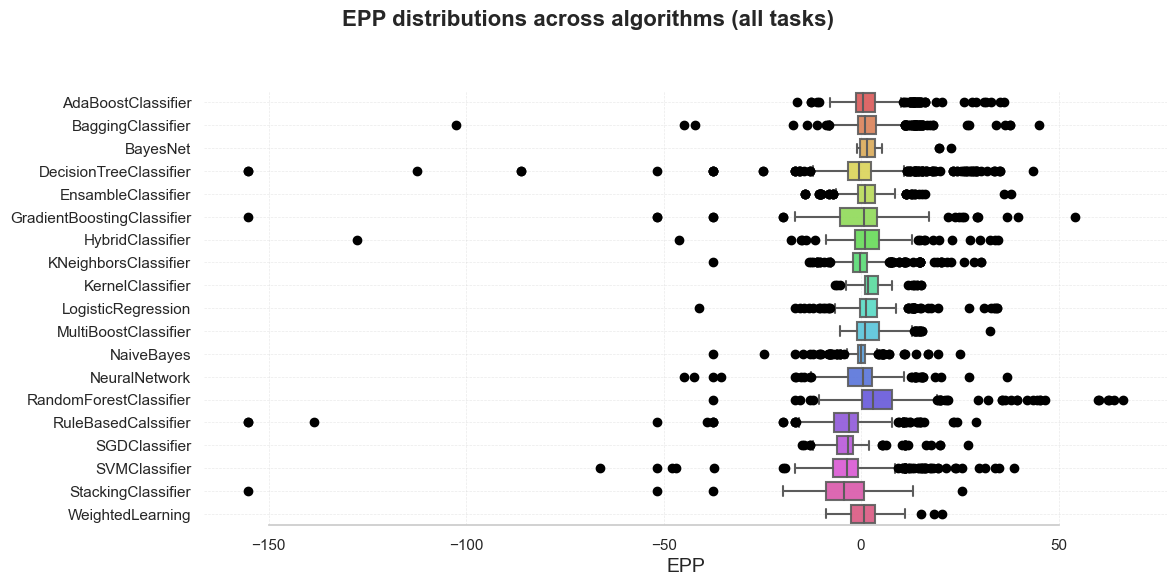

In [ ]:
df_list = []
for k in range(len(epp_score_names)):
    df = pd.DataFrame(bayes_center_epp[k])[['model_name', 'epp']].copy()
    df_list.append(df)
df_all = pd.concat(df_list, ignore_index=True)

models = sorted(df_all['model_name'].unique())

n = len(models)
palette_colors = [
    colorsys.hls_to_rgb(i / n, 0.6, 0.85)
    for i in range(n)
]
model_palette = dict(zip(models, palette_colors))

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    data=df_all,
    y='model_name',
    x='epp',
    order=models,
    palette=model_palette,
    orient="h",
    linewidth=1.5,
    showfliers=True,
    fliersize=6,  
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'black', 
        'markeredgecolor': 'black',
        'alpha': 1.0
    },
    boxprops=dict(alpha=0.9),
    ax=ax
)

fig.suptitle('EPP distributions across algorithms (all tasks)', fontsize=16, fontweight='bold')
ax.set_xlabel('EPP', fontsize=14)
ax.set_ylabel('')

sns.despine(trim=True, left=True)

ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

fig.tight_layout(rect=[0, 0, 1, 0.95])
transparent=True

#plt.savefig("5_algorithm_all_tasks.png", format="png", dpi=200, bbox_inches='tight', transparent=True)

plt.show()


# 5.7 Comparison of EPP distributions across specific flows without task segmentation

### 5.7.1 Boxplot of EPP values for flows without division by task

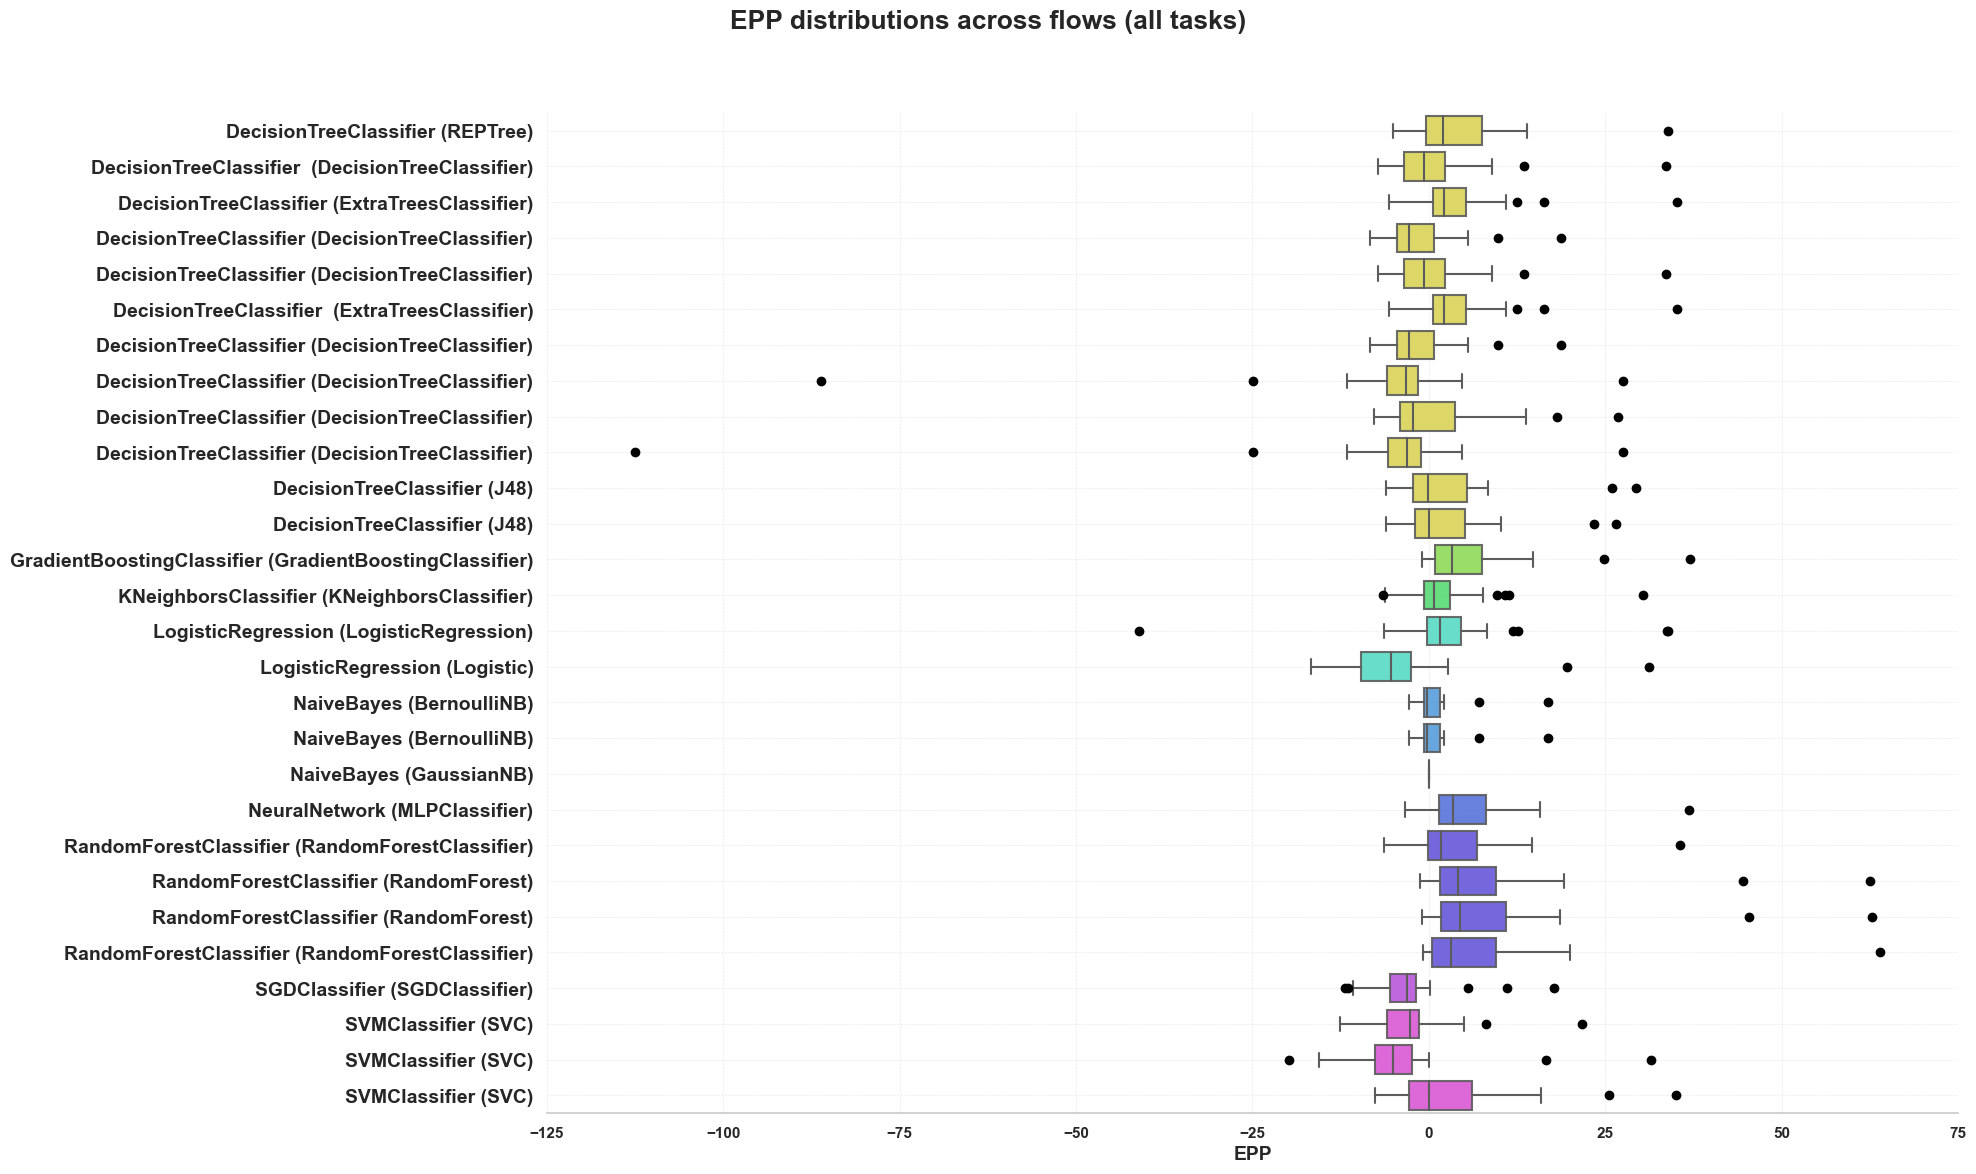

In [ ]:
df_list = []
for k in range(len(bayes_center_epp)):
    df = pd.DataFrame(bayes_center_epp[k])[['flow_id', 'epp', 'model_name']].copy()
    df['task'] = k
    df_list.append(df)
df_all = pd.concat(df_list, ignore_index=True)

task_counts = df_all.groupby('flow_id')['task'].nunique()
valid_players = task_counts[task_counts >= 25].index
df_filtered = df_all[df_all['flow_id'].isin(valid_players)].copy()

df_filtered['model_player'] = (
    df_filtered['model_name'] + ' (' + df_filtered['flow_id'].astype(str) + ')'
)

base_models = set()
for df in epp_score_names_best:
    base_models.update(df['model_name'].unique())
all_models = sorted(base_models)

n_models = len(all_models)
model_palette = {
    model: colorsys.hls_to_rgb(i / n_models, 0.6, 0.85)
    for i, model in enumerate(all_models)
}

model_player_palette = {
    label: model_palette[df_filtered[df_filtered['model_player'] == label]['model_name'].iloc[0]]
    for label in df_filtered['model_player'].unique()
}

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

fig, ax = plt.subplots(figsize=(20, 12))

sns.boxplot(
    data=df_filtered,
    y='model_player',
    x='epp',
    order=sorted(df_filtered['model_player'].unique()),
    palette=model_player_palette,
    orient="h",
    linewidth=1.5,
    showfliers=True,
    fliersize=6,
    flierprops={
        'marker': 'o',
        'markerfacecolor': 'black',
        'markeredgecolor': 'black',
        'alpha': 1.0,
    },
    boxprops=dict(alpha=0.9),
    ax=ax
)

fig.suptitle('EPP distributions across flows (all tasks)', fontsize=19, fontweight='bold')
ax.set_xlabel('EPP', fontsize=14)
ax.set_ylabel('')
ax.set_xlim(-125, 75)

sns.despine(trim=True, left=True)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11,)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_yticklabels(['DecisionTreeClassifier (REPTree)','DecisionTreeClassifier  (DecisionTreeClassifier)','DecisionTreeClassifier (ExtraTreesClassifier)',
                    'DecisionTreeClassifier (DecisionTreeClassifier)','DecisionTreeClassifier (DecisionTreeClassifier)','DecisionTreeClassifier  (ExtraTreesClassifier)',
                    'DecisionTreeClassifier (DecisionTreeClassifier)','DecisionTreeClassifier (DecisionTreeClassifier)','DecisionTreeClassifier (DecisionTreeClassifier)',
                    'DecisionTreeClassifier (DecisionTreeClassifier)','DecisionTreeClassifier (J48)','DecisionTreeClassifier (J48)',
                    'GradientBoostingClassifier (GradientBoostingClassifier)','KNeighborsClassifier (KNeighborsClassifier)',
                    'LogisticRegression (LogisticRegression)','LogisticRegression (Logistic)','NaiveBayes (BernoulliNB)','NaiveBayes (BernoulliNB)',
                    'NaiveBayes (GaussianNB)','NeuralNetwork (MLPClassifier)','RandomForestClassifier (RandomForestClassifier)','RandomForestClassifier (RandomForest)',
                    'RandomForestClassifier (RandomForest)','RandomForestClassifier (RandomForestClassifier)','SGDClassifier (SGDClassifier)','SVMClassifier (SVC)',
                    'SVMClassifier (SVC)','SVMClassifier (SVC)'], fontsize=14,fontweight='bold')

ax.xaxis.label.set_weight('bold')
ax.yaxis.label.set_weight('bold')

for label in ax.get_xticklabels():
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

fig.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig("5_flow_all_tasks.png", format="png", dpi=200, bbox_inches='tight', transparent=True)
plt.show()

# 6. Overview figures for all tasks

### 6.1 epp vs auc

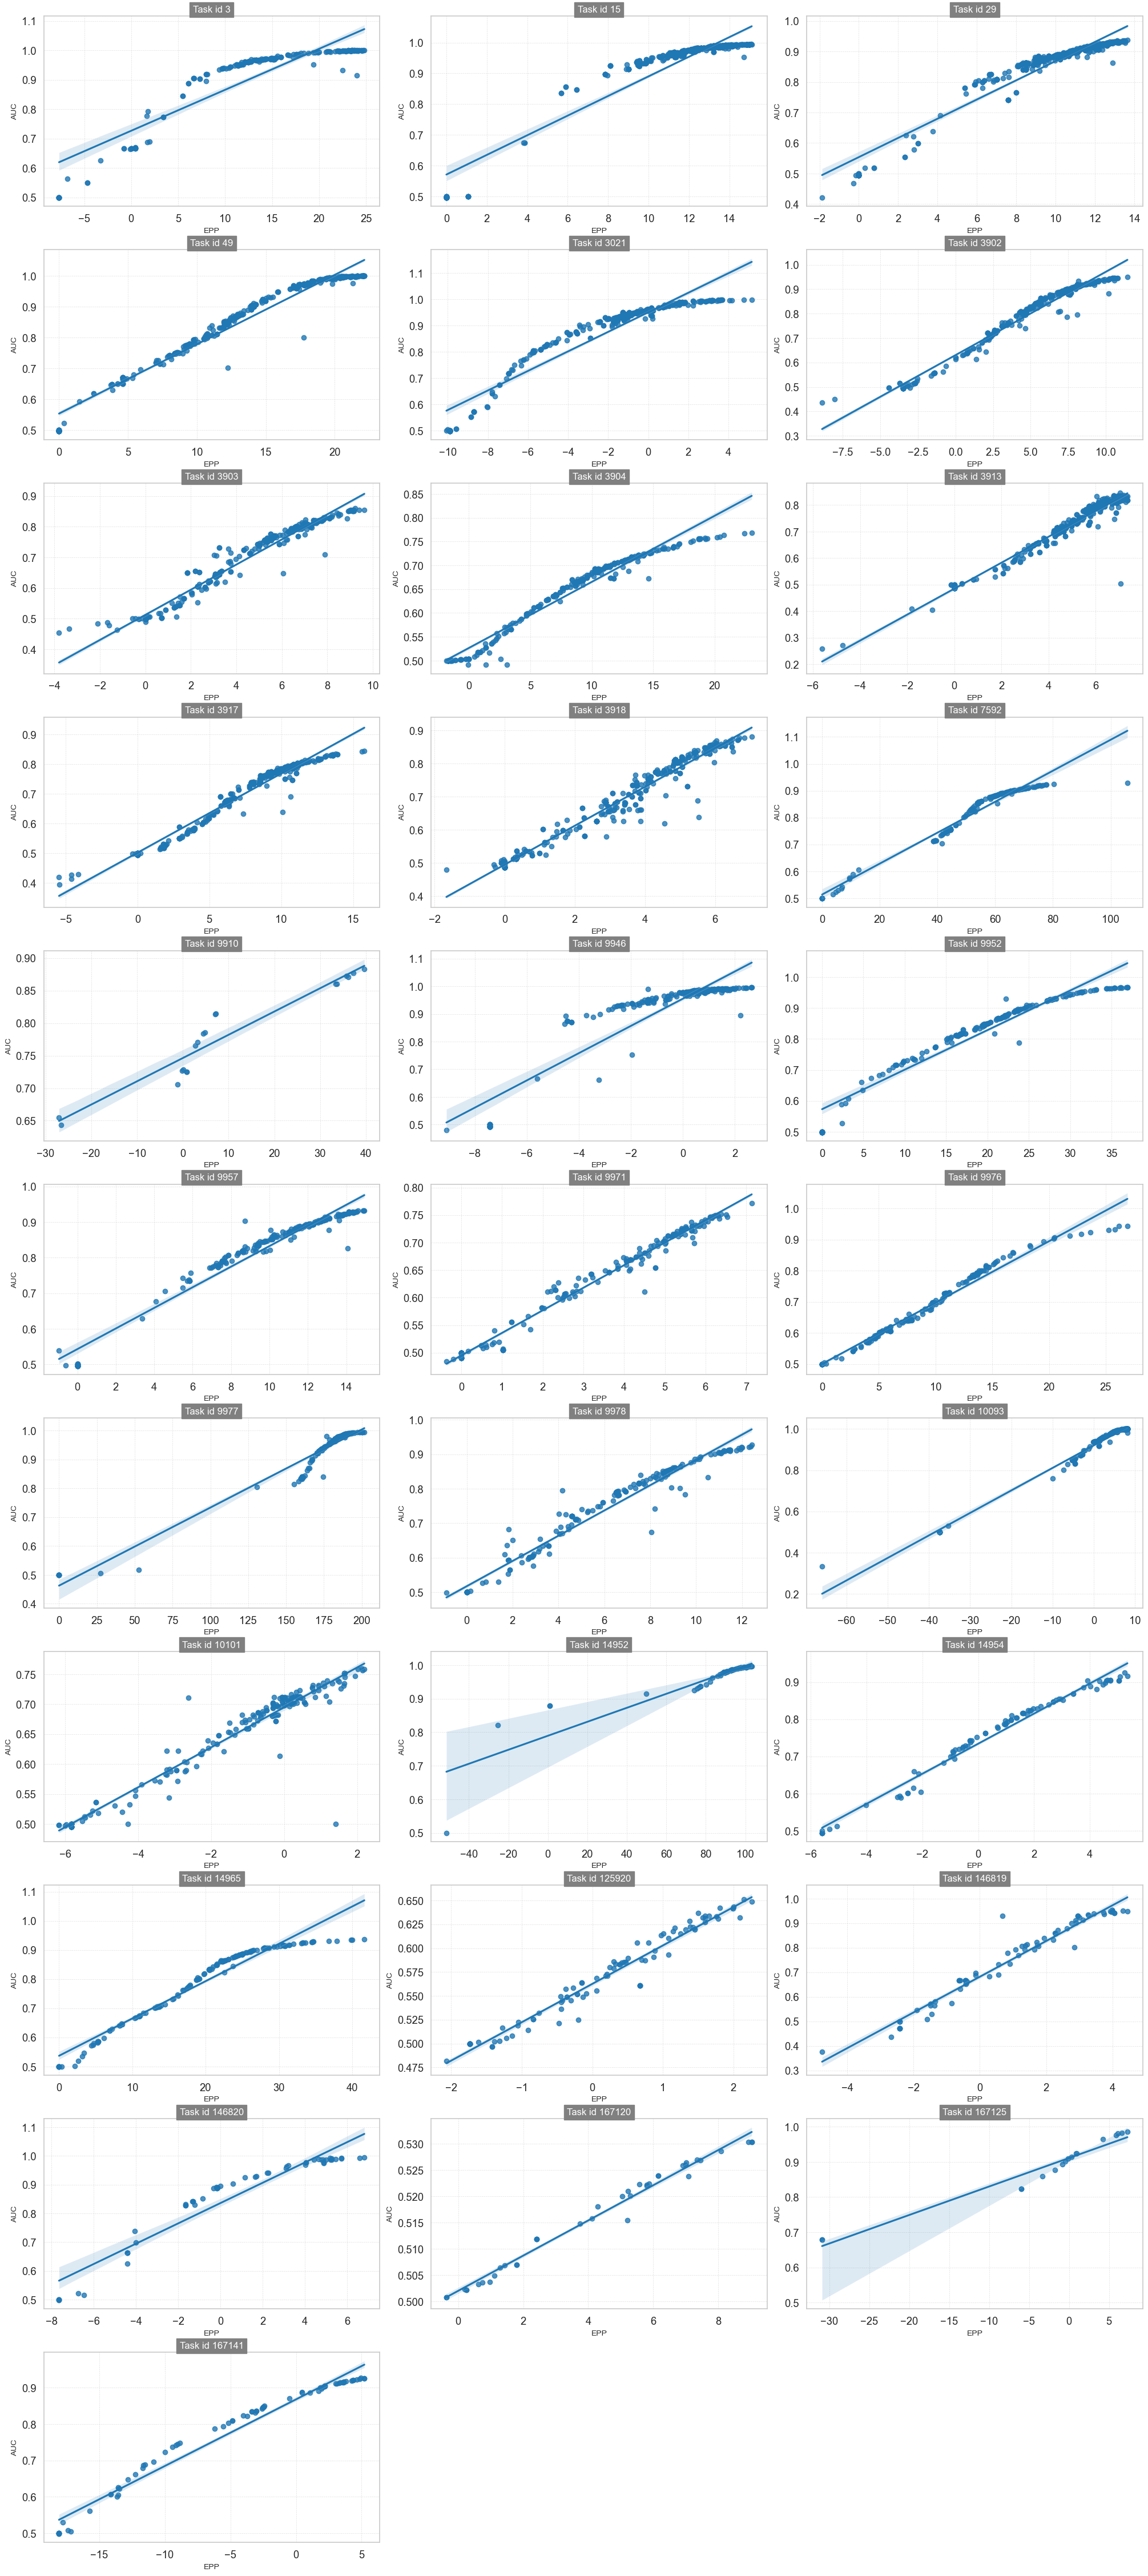

In [166]:
sns.set_style("whitegrid")
rows, cols = 11, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 45), constrained_layout=True)

for i in range(len(epp_auc)):
    row, col = i // cols, i % cols
    ax = axes[row, col]
    sns.regplot(data= epp_auc[i], x = 'epp', y = 'auc', ax = ax)
    ax.set_title(f'Task id {tasks_id[i]}', fontsize=12, backgroundcolor='gray', color='white', pad=5)
    ax.set_xlabel('EPP', fontsize=10)
    ax.set_ylabel('AUC', fontsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])
plt.show()

### 6.2 boxplots

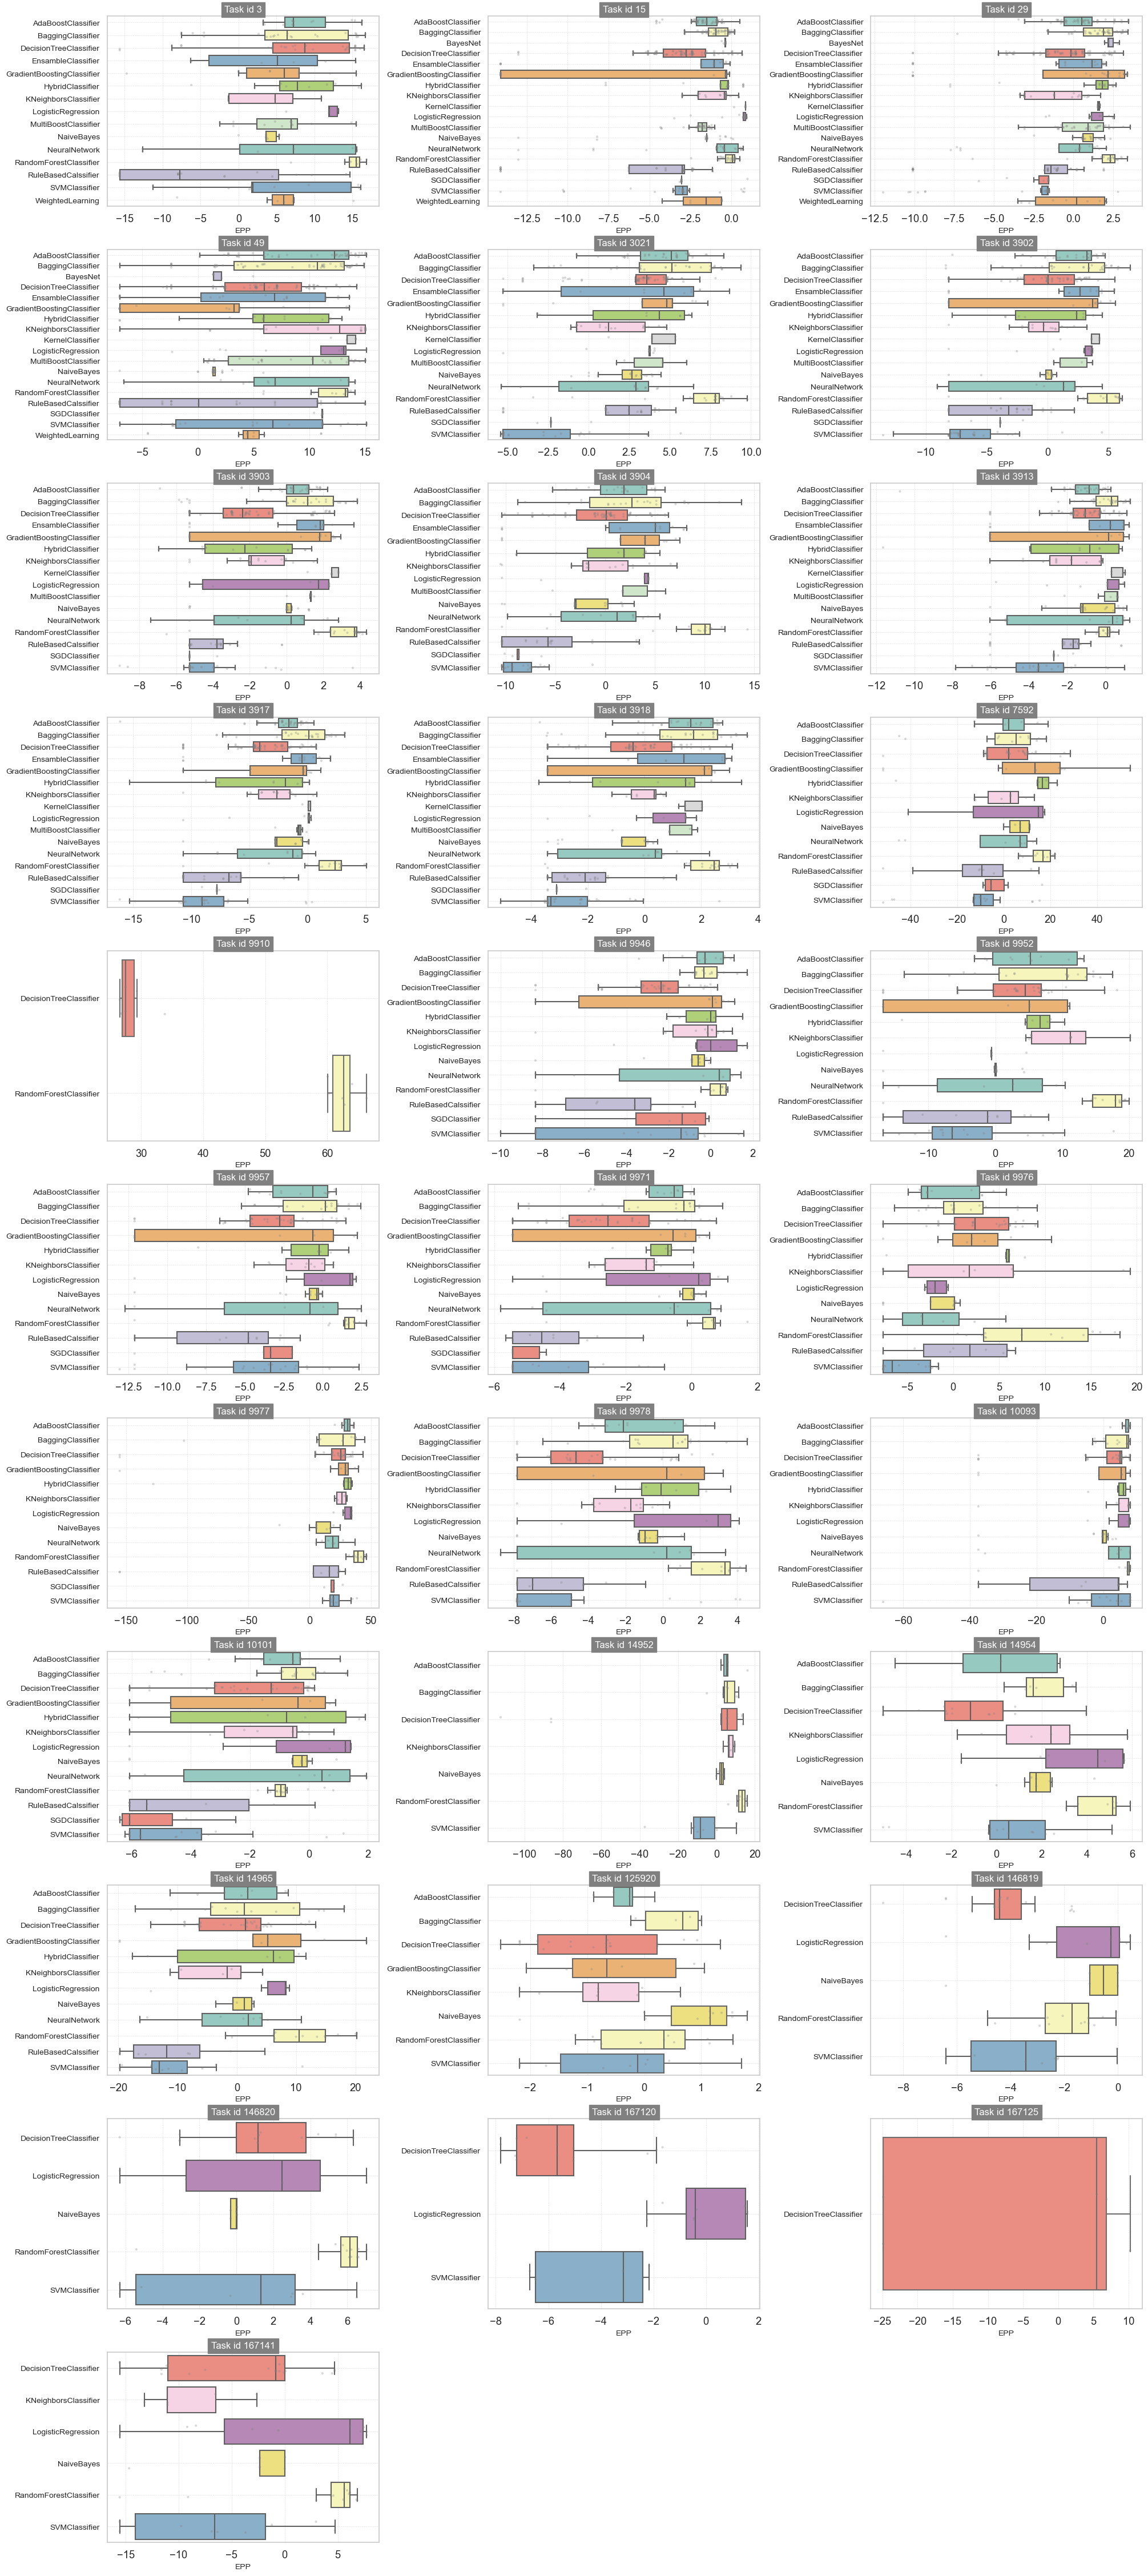

In [ ]:
sns.set_style("whitegrid")

rows, cols = 11, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 45), constrained_layout=True)  
threshold = 4
num_plots = min(len(epp_score), rows * cols)

all_models = set()
for df in bayes_center_epp:
    vc = df['model_name'].value_counts()
    keep = vc[vc > threshold].index.tolist()
    all_models.update(keep)
all_models = sorted(all_models)

palette_colors = sns.color_palette("Set3", n_colors=len(all_models))
global_palette = dict(zip(all_models, palette_colors))

for i in range(num_plots):
    df = bayes_center_epp[i]
    vc = df['model_name'].value_counts()
    keep = vc[vc > threshold].index
    filtered_df = df[df['model_name'].isin(keep)]
    
    order = [m for m in all_models if m in keep]
    
    row, col = divmod(i, cols)
    ax = axes[row, col]

    sns.boxplot(
        y='model_name',
        x='epp',
        data=filtered_df,
        ax=ax,
        palette=global_palette,
        order=order,
        orient="h",
        showfliers=False
    )
    sns.stripplot(
        y='model_name',
        x='epp',
        data=filtered_df,
        ax=ax,
        order=order,
        orient="h",
        jitter=0.2,
        size=3,
        alpha=0.3,
        color='gray'
    )

    ax.set_title(
        f'Task id {tasks_id[i]}', 
        fontsize=12, backgroundcolor='gray', color='white', pad=5
    )
    ax.set_xlabel('EPP', fontsize=10)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.show()
